<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/multi_stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

#### **Imports and installs**

In [21]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript, clear_output
import os
import shutil
from datetime import datetime

!pip install tensorflow==2.4.0-rc4 --quiet
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install scikit-learn==0.24.0rc1 --quiet

!pip install yahooquery --quiet
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks --quiet

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import MultiStocksDataset
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback
from stocks.technical_indicators.moving_averages import sma, ema, macd
from stocks.technical_indicators.others import stochastic_oscillator

try:
  from google.colab import files
  COLAB = True
except ImportError:
  COLAB = False

if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


####**Settings**

In [22]:
NUM_SESSIONS = 10  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = .85, .10, .05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

NUM_SESSIONS_PER_STOCK_PER_BATCH = 5
MAX_ZERO_VOL_PC = 0.2
INTERVAL = "1d"

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

TECHNICAL_INDICATORS_COLS = ["close", "open", "high", "low"]
TECHNICAL_INDICATORS = [
    # simple moving average
    (sma, {"n": 5}),
    (sma, {"n": 10}),
    (sma, {"n": 20}),
    (sma, {"n": 50}),
    (sma, {"n": 100}),

    # exponential moving average
    (ema, {"n": 5}),
    (ema, {"n": 10}),
    (ema, {"n": 20}),
    (ema, {"n": 50}),
    (ema, {"n": 100}),

    # moving average convergence divergence
    (macd, {}),

    # others
    (stochastic_oscillator, {}),
]

NAME_LIST = set([
    # South America
    "^BVSP",                                        # Brazil
    # North America
    "^NYA",                                         # US
    "^MXX",                                         # Mexico
    "^GSPTSE",                                      # Canada
    # Europe
    "^FCHI", "^GDAXI", "^IBEX", "^AEX", "^ATX", 
    # Asia
    "000001.SS",                                    # China 
    "^N225",                                        # Japan
    "^KS11",                                        # S. Korea 
    "^BSESN",                                       # India
    # Oceania
    "^AORD",                                        # Australia
    
])

# loading stocks with specific params:
STOCKS = {
    # US
    "^DJI": {"start": "1997-01-01", "end": "2020-12-11", "period": None},
    "^IXIC": {"start": "2003-01-01", "end": "2020-12-11", "period": None},
    "^RUT": {"start": "2012-01-01", "end": "2020-12-11", "period": None},

    # EU
    "^FTSE": {"start": "2000-01-01", "end": "2020-12-11", "period": None},
    "^N100": {"start": "2014-01-01", "end": "2020-12-11", "period": None},
    "^BFX": {"start": "2018-01-01", "end": "2020-12-11", "period": None},

    # CH
    "^HSI": {"start": "2004-01-01", "end": "2020-12-11", "period": None},
    "^TWII": {"start": "2014-01-01", "end": "2020-12-11", "period": None},
    "399001.SZ": {"start": "2019-01-01", "end": "2020-12-11", "period": None},
}

# loading stocks from NAME_LIST with default info (same params for all):
STOCKS.update({name: {"start": "2006-01-01",
                      "end": "2020-12-11",
                      "period": None} \
               for name in NAME_LIST})

## **1) Preparing the data**

####**1.1) Fetching and pre-processing the data**

In [23]:
ts = timer()
sess_counter = i = 0
removed_symbols = []
multi_data = {}
for name, info in STOCKS.items():
    clear_output(wait=True)
    print(f"[{100 * i / len(STOCKS) : .0f}%] Processing symbol \"{name}\".")
    i += 1

    print("Fetching data... ", end="")
    hist = Ticker(name).history(
        start=info["start"],
        end=info["end"],
        period=info["period"], 
        interval=INTERVAL
    ).reset_index("symbol", drop=True)
    hist = hist[["high", "close", "open", "low", "volume"]]
    
    print(" done!")
    zero_vols_pc = hist["volume"].isin([0]).sum() / len(hist)
    if zero_vols_pc > MAX_ZERO_VOL_PC:
        removed_symbols.append(name)
    else:
        print("Calculating technical indicators... ", end="")
        for func, params in TECHNICAL_INDICATORS:
            hist.index = pd.to_datetime(hist.index)
            hist = pd.concat([hist, 
                              func(hist[TECHNICAL_INDICATORS_COLS], **params)], axis=1)

        sess_counter += len(hist)
        multi_data[name] = hist


clear_output(wait=True)
print("Building multi-stocks dataset... ", end="")

multi_data = MultiStocksDataset(
    stocks=multi_data, 
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    batch_size=len(multi_data) * NUM_SESSIONS_PER_STOCK_PER_BATCH,
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,
)

print(f"done! Elapsed time: {timer() - ts : .2f}s")
print(f"Number of trading sessions: {sess_counter}")

if removed_symbols:
    print(f"WARNING: {len(removed_symbols)} symbols removed because {100*MAX_ZERO_VOL_PC : .2f}% " 
          f"or more of their volumes are 0! List: {removed_symbols}")

Building multi-stocks dataset... done! Elapsed time:  42.73s
Number of trading sessions: 79239


#### **1.2) Inspecting the data**



###################################   ^BVSP   ###################################

. Period: from 2006-01-02 00:00:00 to 2020-12-10 00:00:00
. Trading sessions: 3690
. Zero volumes:  5.77%
. Data:



high     close      open  ...    high_macd     low_macd       %K14
date                                      ...                                     
2006-01-02   33519.0   33507.0   33462.0  ...     0.000000     0.000000  -1.000000
2006-01-03   34563.0   34541.0   33507.0  ...    83.282051    51.612536  -1.000000
2006-01-04   35223.0   35002.0   34540.0  ...   200.232011   173.866089  -1.000000
2006-01-05   35088.0   34936.0   35006.0  ...   278.808395   278.915270  -1.000000
2006-01-06   35529.0   35475.0   35170.0  ...   372.373273   378.701207  -1.000000
...              ...       ...       ...  ...          ...          ...        ...
2020-12-04  113864.0  113682.0  112294.0  ...  3119.947071  3228.438138  98.007663
2020-12-07  114531.0  113625.0  113751.0  ...  3199.888673  3292.416506  89.917650
2020-12-08  114381.0  113571.0  113590.0  ...  3214.089202  3320.258058  89.316715
2020-12-09  114020.0  112722.0  113799.0  ...  3159.789455  3284.051206  79.868685
2020-12-10  115262.0  114992.0  113002.0  ...  3180.314845  3231.421322  97.069040

[3690 rows x 50 columns]


. Statistics:



high          close  ...      low_macd         %K14
count    3690.000000    3690.000000  ...   3690.000000  3690.000000
mean    63491.371545   62858.518157  ...    136.736239    56.062740
std     18398.134620   18300.739406  ...   1304.931871    31.611403
min     31480.000000   29435.000000  ... -12664.484815    -1.000000
25%     51606.250000   51132.750000  ...   -466.248407    27.060068
50%     59543.500000   59085.500000  ...    201.436424    60.820592
75%     69940.250000   69358.750000  ...    912.564181    85.345682
max    119593.000000  119528.000000  ...   4200.902510   100.000000

[8 rows x 50 columns]


. Plot:



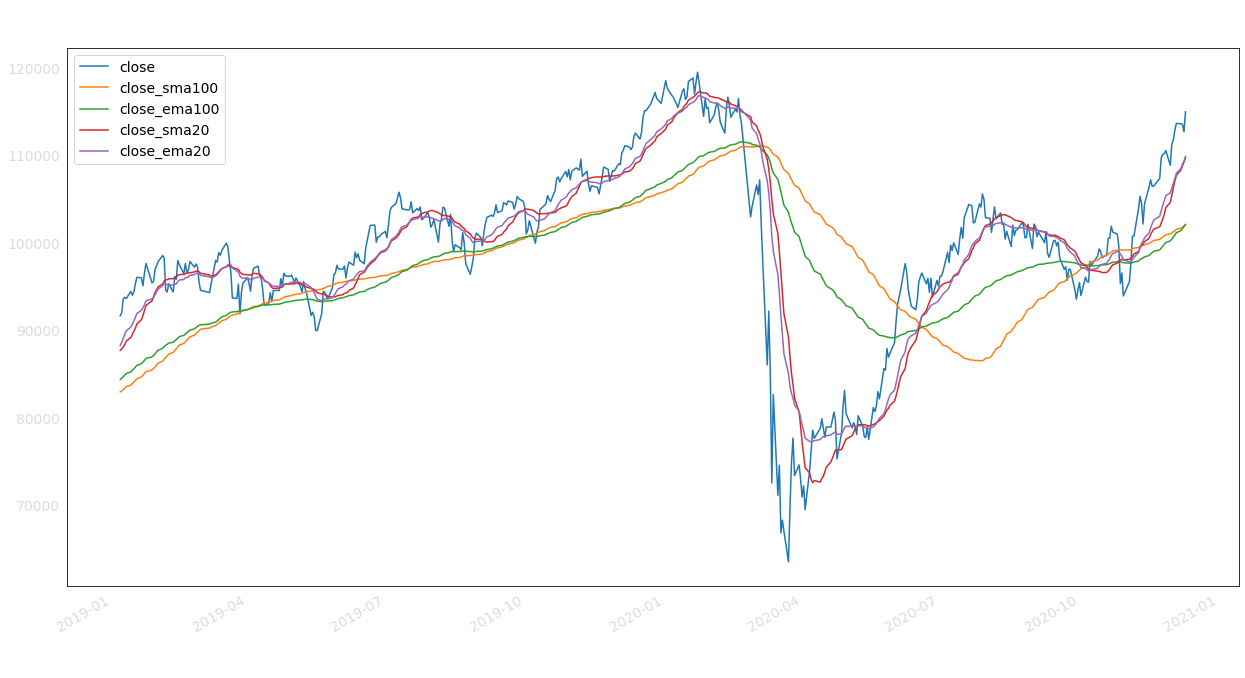

In [24]:
#@title
symbol = "^BVSP"  #@param {type:"string"}
cols_to_plot = "close close_sma100 close_ema100 close_sma20 close_ema20"  #@param {type:"string"}
date_from = "2019-01-04"  #@param {type:"string"}
date_to = "2020-12-10"  #@param {type:"string"}

pdata = multi_data[symbol].raw
zero_vols_pc = pdata["volume"].isin([0]).sum() / len(pdata)
print("\n\n" + "#"*35 + f"   {symbol}   " + "#"*35 + "\n\n" +
        f". Period: from {pdata.index[0]} to {pdata.index[-1]}\n" +
        f". Trading sessions: {len(pdata)}\n" +
        f". Zero volumes: {100*zero_vols_pc : .2f}%\n" 
        f". Data:\n")
display(pdata)

print(f"\n. Statistics:\n")
display(pdata.describe())

print(f"\n. Plot:\n")

pdata[cols_to_plot.split()] \
   [(pdata.index > date_from) & (pdata.index <= date_to)] \
        .plot(figsize=(21, 11))
        
plt.title(f"{symbol}\n", fontsize=18, color="#ffffff");
plt.xlabel("\nDate", fontsize="16", color="#ffffff");
plt.tick_params(axis='both', which='major', labelsize=14, color="#ffffff")
plt.show()

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

In [25]:
# data division dates
for symbol, data in multi_data.stocks:
    print(f">>>>> {symbol}")
    print(". Training range: %s to %s" % (
        data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
    print(". Validation range: %s to %s" % (
        data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
    print(". Test range: %s to %s\n" % (
        data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))
    
if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

>>>>> ^DJI
. Training range: 1997-01-02 00:00:00 to 2017-04-25 00:00:00
. Validation range: 2017-04-26 00:00:00 to 2019-09-16 00:00:00
. Test range: 2019-09-17 00:00:00 to 2020-11-25 00:00:00

>>>>> ^IXIC
. Training range: 2003-01-02 00:00:00 to 2018-03-20 00:00:00
. Validation range: 2018-03-21 00:00:00 to 2020-01-03 00:00:00
. Test range: 2020-01-06 00:00:00 to 2020-11-25 00:00:00

>>>>> ^RUT
. Training range: 2012-01-03 00:00:00 to 2019-07-25 00:00:00
. Validation range: 2019-07-26 00:00:00 to 2020-06-16 00:00:00
. Test range: 2020-06-17 00:00:00 to 2020-11-25 00:00:00

>>>>> ^FTSE
. Training range: 2000-01-04 00:00:00 to 2017-10-11 00:00:00
. Validation range: 2017-10-12 00:00:00 to 2019-11-12 00:00:00
. Test range: 2019-11-13 00:00:00 to 2020-11-26 00:00:00

>>>>> ^N100
. Training range: 2014-01-02 00:00:00 to 2019-11-11 00:00:00
. Validation range: 2019-11-12 00:00:00 to 2020-07-23 00:00:00
. Test range: 2020-07-24 00:00:00 to 2020-11-26 00:00:00

>>>>> ^BFX
. Training range: 201

In [26]:
# comparing normalized values of the training sets
print("#"*20 + " Normalized training data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_train["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized training data ####################

>>>>> ^DJI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2017-04-19  0.957699  0.951707  0.957563  ...   0.592628  0.631468  0.058513
2017-04-20  0.963346  0.963539  0.950991  ...   0.592810  0.626060  0.398106
2017-04-21  0.961417  0.961437  0.962623  ...   0.590988  0.630002  0.337775
2017-04-24  0.974384  0.976116  0.972496  ...   0.606444  0.650449  0.759060
2017-04-25  0.990340  0.991889  0.985519  ...   0.639040  0.681089  0.952819

[5 rows x 50 columns]


>>>>> ^IXIC


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-03-14  0.985470  0.985520  0.986206  ...   0.806829  0.860508  0.748264
2018-03-15  0.982410  0.983135  0.981404  ...   0.801146  0.862693  0.721255
2018-03-16  0.980644  0.983175  0.980638  ...   0.790170  0.863596  0.721703
2018-03-19  0.966019  0.961378  0.967248  ...   0.752154  0.809344  0.474823
2018-03-20  0.959650  0.964552  0.956879  ...   0.708165  0.776296  0.510775

[5 rows x 50 columns]


>>>>> ^RUT


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-07-19  0.819354  0.807825  0.815359  ...   0.674041  0.685963  0.055579
2019-07-22  0.812080  0.804715  0.810203  ...   0.660531  0.675064  0.047378
2019-07-23  0.812990  0.814860  0.806618  ...   0.650275  0.666891  0.360104
2019-07-24  0.839437  0.840231  0.814534  ...   0.665405  0.664791  0.968532
2019-07-25  0.838016  0.821327  0.840480  ...   0.675458  0.671033  0.475170

[5 rows x 50 columns]


>>>>> ^FTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2017-10-05  0.977980  0.990706  0.981223  ...   0.730325  0.741397  1.000000
2017-10-06  0.982747  0.994203  0.990706  ...   0.750504  0.763258  0.983353
2017-10-09  0.981779  0.990682  0.994203  ...   0.764961  0.777271  0.931334
2017-10-10  0.986667  0.997817  0.990682  ...   0.779260  0.789207  0.981622
2017-10-11  0.988192  0.996761  0.997817  ...   0.790692  0.800068  0.947279

[5 rows x 50 columns]


>>>>> ^N100


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-11-05  0.976498  0.978825  0.965927  ...   0.699733  0.726916  0.978327
2019-11-06  0.990182  0.990084  0.978445  ...   0.720856  0.747587  0.962781
2019-11-07  0.998248  1.000000  1.000000  ...   0.740268  0.770039  0.983709
2019-11-08  0.995188  0.996856  0.988427  ...   0.751344  0.781386  0.956477
2019-11-11  1.000000  0.997581  0.988373  ...   0.760556  0.789232  0.948856

[5 rows x 50 columns]


>>>>> ^BFX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-06-16  0.559693  0.550379  0.531166  ...   0.932452  0.920356  0.684693
2020-06-17  0.558390  0.546342  0.552293  ...   0.933440  0.926325  0.666712
2020-06-18  0.548804  0.530200  0.545965  ...   0.929350  0.923167  0.571027
2020-06-19  0.524575  0.507805  0.550601  ...   0.917409  0.917707  0.465423
2020-06-22  0.508491  0.511818  0.497805  ...   0.901633  0.905721  0.484346

[5 rows x 50 columns]


>>>>> ^HSI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-05-09  0.869569  0.882001  0.870715  ...   0.486115  0.530757  0.704265
2018-05-10  0.882210  0.894309  0.882589  ...   0.498287  0.546627  0.959034
2018-05-11  0.901273  0.908410  0.902086  ...   0.519692  0.567304  0.896473
2018-05-14  0.915374  0.927296  0.917625  ...   0.545083  0.593334  0.971694
2018-05-15  0.914506  0.909761  0.920980  ...   0.564247  0.606397  0.757777

[5 rows x 50 columns]


>>>>> ^TWII


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-11-07  0.994805  0.989038  0.999486  ...   0.997757  0.998318  0.882711
2019-11-08  0.993537  0.982669  0.994265  ...   1.000000  1.000000  0.808795
2019-11-11  0.975473  0.946782  0.982277  ...   0.986124  0.973934  0.480431
2019-11-12  0.962952  0.968723  0.956908  ...   0.963339  0.957766  0.646125
2019-11-13  0.960196  0.956339  0.961629  ...   0.940108  0.938572  0.487149

[5 rows x 50 columns]


>>>>> 399001.SZ


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-08-05  0.977308  0.973340  0.963093  ...   0.640271  0.701864  0.956325
2020-08-06  0.974225  0.959487  0.979007  ...   0.634847  0.695371  0.873834
2020-08-07  0.956182  0.929085  0.956675  ...   0.617149  0.666647  0.692800
2020-08-10  0.942492  0.930333  0.923230  ...   0.592335  0.643723  0.700230
2020-08-11  0.951035  0.903272  0.936187  ...   0.573954  0.622003  0.539094

[5 rows x 50 columns]


>>>>> ^BVSP


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-21  0.789261  0.785754  0.805501  ...   0.600520  0.615415  0.048054
2018-08-22  0.799184  0.815332  0.785642  ...   0.588653  0.595499  0.299944
2018-08-23  0.804954  0.793552  0.815310  ...   0.583790  0.587657  0.118842
2018-08-24  0.794345  0.804339  0.793819  ...   0.573322  0.584368  0.209767
2018-08-27  0.818607  0.832990  0.804418  ...   0.582314  0.590010  0.510856

[5 rows x 50 columns]


>>>>> 000001.SS


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-16  0.313966  0.310364  0.312155  ...   0.476196  0.504567  0.152916
2018-08-17  0.313436  0.302988  0.318789  ...   0.470840  0.497596  0.024312
2018-08-20  0.306990  0.308995  0.308403  ...   0.462406  0.491054  0.193721
2018-08-21  0.315225  0.316195  0.313977  ...   0.463054  0.493111  0.502496
2018-08-22  0.313765  0.312282  0.320438  ...   0.463284  0.497407  0.407847

[5 rows x 50 columns]


>>>>> ^N225


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-14  0.895866  0.896417  0.880966  ...   0.595606  0.624732  0.536360
2018-08-15  0.897287  0.887521  0.899477  ...   0.588197  0.616014  0.377973
2018-08-16  0.889073  0.886807  0.876721  ...   0.575750  0.598078  0.365267
2018-08-17  0.894977  0.891397  0.896250  ...   0.571271  0.602302  0.446977
2018-08-20  0.891886  0.887215  0.893540  ...   0.565584  0.601597  0.372527

[5 rows x 50 columns]


>>>>> ^MXX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-24  0.951759  0.940685  0.946426  ...   0.732574  0.736552  0.794498
2018-08-27  0.963129  0.963003  0.948411  ...   0.756394  0.756749  0.973697
2018-08-28  0.966507  0.951814  0.969292  ...   0.777446  0.772140  0.789425
2018-08-29  0.956040  0.956478  0.955847  ...   0.781469  0.786400  0.848845
2018-08-30  0.954929  0.941237  0.959563  ...   0.781983  0.777479  0.654650

[5 rows x 50 columns]


>>>>> ^AEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-23  0.959406  0.954031  0.958331  ...   0.688774  0.696656  0.363287
2018-08-24  0.959113  0.957691  0.958464  ...   0.690493  0.702036  0.416411
2018-08-27  0.966796  0.967877  0.965600  ...   0.698015  0.710385  0.572102
2018-08-28  0.969720  0.964959  0.974227  ...   0.706537  0.720473  0.575552
2018-08-29  0.969906  0.970583  0.971990  ...   0.713753  0.726748  0.813024

[5 rows x 50 columns]


>>>>> ^KS11


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-21  0.796281  0.802265  0.795424  ...   0.528244  0.585145  0.554058
2018-08-22  0.800822  0.804235  0.810745  ...   0.537087  0.596801  0.614177
2018-08-23  0.802388  0.809821  0.816057  ...   0.546149  0.606389  0.715583
2018-08-24  0.809909  0.816215  0.812227  ...   0.559748  0.615975  0.831646
2018-08-27  0.814572  0.819885  0.824870  ...   0.574601  0.631617  0.898266

[5 rows x 50 columns]


>>>>> ^ATX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-27  0.528213  0.533183  0.527375  ...   0.662573  0.671348  0.343762
2018-08-28  0.530203  0.537214  0.533134  ...   0.666185  0.676795  0.426139
2018-08-29  0.533257  0.537654  0.536969  ...   0.671312  0.681934  0.527541
2018-08-30  0.531762  0.533931  0.538153  ...   0.674701  0.686448  0.622485
2018-08-31  0.528110  0.528807  0.533809  ...   0.675330  0.686615  0.608513

[5 rows x 50 columns]


>>>>> ^AORD


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-29  0.888720  0.894011  0.892425  ...   0.712096  0.711256  1.000000
2018-08-30  0.895217  0.894946  0.904170  ...   0.723607  0.725419  0.863526
2018-08-31  0.890457  0.886207  0.905118  ...   0.728212  0.729909  0.621641
2018-09-03  0.884522  0.883188  0.896268  ...   0.726430  0.730403  0.529631
2018-09-04  0.879094  0.878484  0.893210  ...   0.720063  0.723580  0.401876

[5 rows x 50 columns]


>>>>> ^IBEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-24  0.355142  0.363706  0.359177  ...   0.620221  0.630207  0.531995
2018-08-27  0.358851  0.370743  0.366332  ...   0.628442  0.639853  0.707654
2018-08-28  0.359696  0.365407  0.369915  ...   0.636112  0.648081  0.643545
2018-08-29  0.352256  0.361703  0.361765  ...   0.636953  0.647813  0.687446
2018-08-30  0.349944  0.351503  0.357824  ...   0.636339  0.643777  0.392384

[5 rows x 50 columns]


>>>>> ^FCHI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-24  0.801281  0.798389  0.798084  ...   0.673518  0.672879  0.580337
2018-08-27  0.811710  0.811160  0.807051  ...   0.687359  0.686595  0.792391
2018-08-28  0.817051  0.812774  0.816427  ...   0.702736  0.703635  0.901840
2018-08-29  0.816376  0.817253  0.818197  ...   0.714177  0.716596  0.975517
2018-08-30  0.814841  0.810875  0.817667  ...   0.721695  0.724468  0.870591

[5 rows x 50 columns]


>>>>> ^GSPTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-24  0.979125  0.976523  0.980284  ...   0.707152  0.753850  0.673749
2018-08-27  0.987493  0.986334  0.983971  ...   0.714913  0.762339  0.923514
2018-08-28  0.986324  0.976457  0.989373  ...   0.720298  0.763430  0.703464
2018-08-29  0.982725  0.980323  0.980041  ...   0.722241  0.764867  0.789604
2018-08-30  0.983433  0.978246  0.979454  ...   0.724157  0.766577  0.743315

[5 rows x 50 columns]


>>>>> ^GDAXI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-20  0.876293  0.875844  0.867261  ...   0.419962  0.448130  0.302639
2018-08-21  0.882289  0.881220  0.873074  ...   0.424553  0.455309  0.432681
2018-08-22  0.882896  0.881343  0.876606  ...   0.430210  0.465506  0.434620
2018-08-23  0.880100  0.879309  0.877813  ...   0.432927  0.475685  0.402380
2018-08-24  0.883471  0.882234  0.880764  ...   0.440032  0.483838  0.448753

[5 rows x 50 columns]


>>>>> ^BSESN


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-17  0.984607  0.987113  0.982910  ...   0.762150  0.771829  0.865841
2018-08-20  0.995139  0.998078  0.988732  ...   0.768272  0.775152  0.949387
2018-08-21  0.997199  0.998310  0.998142  ...   0.773020  0.781491  0.908907
2018-08-23  1.000000  1.000000  1.000000  ...   0.777525  0.784430  0.890057
2018-08-24  0.998077  0.997185  0.998355  ...   0.776126  0.782081  0.800095

[5 rows x 50 columns]


>>>>> ^NYA


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2018-08-23  0.930350  0.925238  0.934425  ...   0.769089  0.797964  0.731496
2018-08-24  0.932870  0.932250  0.933382  ...   0.772068  0.801839  0.898472
2018-08-27  0.943499  0.943151  0.941347  ...   0.784336  0.812168  0.981435
2018-08-28  0.945624  0.941320  0.950092  ...   0.795298  0.822663  0.906178
2018-08-29  0.947548  0.946353  0.947264  ...   0.804913  0.829945  0.967809

[5 rows x 50 columns]

In [27]:
# comparing normalized values of the validation sets
print("#"*20 + " Normalized validation data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_val["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized validation data ####################

>>>>> ^DJI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-09-10  1.390126  1.393503  1.385220  ...   0.706054  0.777743  1.000000
2019-09-11  1.405595  1.408962  1.393514  ...   0.749711  0.812346  1.000000
2019-09-12  1.417128  1.412046  1.411786  ...   0.797177  0.854836  0.931621
2019-09-13  1.415145  1.414563  1.413099  ...   0.830002  0.892948  0.948273
2019-09-16  1.408030  1.404872  1.408308  ...   0.844495  0.907891  0.863635

[5 rows x 50 columns]


>>>>> ^IXIC


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-12-27  1.222523  1.224426  1.223558  ...   0.968530  1.003414  0.900415
2019-12-30  1.215344  1.214832  1.216480  ...   0.966725  0.986583  0.767365
2019-12-31  1.210468  1.219043  1.203005  ...   0.951333  0.969294  0.817023
2020-01-02  1.229039  1.237966  1.221985  ...   0.967446  0.977578  0.997332
2020-01-03  1.224687  1.226665  1.212075  ...   0.967022  0.969715  0.818262

[5 rows x 50 columns]


>>>>> ^RUT


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-06-10  0.764699  0.727596  0.767699  ...   1.284414  1.249471  0.658525
2020-06-11  0.716068  0.616815  0.719423  ...   1.229967  1.142653  0.099684
2020-06-12  0.670609  0.648165  0.628652  ...   1.139890  1.048057  0.211308
2020-06-15  0.683547  0.679983  0.643005  ...   1.074885  0.964233  0.397786
2020-06-16  0.731488  0.712519  0.693606  ...   1.061405  0.964856  0.564401

[5 rows x 50 columns]


>>>>> ^FTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2019-11-06  0.951556  0.964582  0.962564  ...   0.757403  0.770744  0.977072
2019-11-07  0.959565  0.966859  0.964582  ...   0.770013  0.785306  0.913684
2019-11-08  0.953492  0.955828  0.966859  ...   0.774402  0.787875  0.748309
2019-11-11  0.942022  0.948575  0.955828  ...   0.768162  0.773678  0.569486
2019-11-12  0.949427  0.957236  0.948575  ...   0.768138  0.773427  0.647340

[5 rows x 50 columns]


>>>>> ^N100


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-07-17  0.671302  0.675087  0.682017  ...   0.780240  0.818688  0.763819
2020-07-20  0.680842  0.692796  0.667935  ...   0.778794  0.807069  0.877097
2020-07-21  0.722062  0.706178  0.712447  ...   0.800049  0.827409  0.786085
2020-07-22  0.687295  0.668557  0.698365  ...   0.792583  0.817647  0.507240
2020-07-23  0.679841  0.672534  0.682260  ...   0.779330  0.807821  0.536719

[5 rows x 50 columns]


>>>>> ^BFX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-09-29  0.407228  0.422949  0.438393  ...   0.636770  0.677252  0.337867
2020-09-30  0.415330  0.423272  0.421596  ...   0.641223  0.677442  0.340130
2020-10-01  0.415136  0.424081  0.440128  ...   0.645691  0.680576  0.345788
2020-10-02  0.405582  0.430933  0.437352  ...   0.647615  0.686983  0.393729
2020-10-05  0.434058  0.458282  0.464665  ...   0.657699  0.699907  0.585077

[5 rows x 50 columns]


>>>>> ^HSI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-01-16  0.798834  0.807492  0.796908  ...   0.679068  0.693683  0.795749
2020-01-17  0.803908  0.815306  0.805071  ...   0.679752  0.694624  0.928636
2020-01-20  0.807208  0.803564  0.813185  ...   0.680546  0.693336  0.715108
2020-01-21  0.776656  0.767030  0.780913  ...   0.660922  0.670025  0.105814
2020-01-22  0.772267  0.783062  0.765987  ...   0.641365  0.649378  0.373192

[5 rows x 50 columns]


>>>>> ^TWII


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-07-21  1.195967  1.175472  1.141603  ...   1.121783  1.106108  0.931390
2020-07-22  1.205187  1.193319  1.176560  ...   1.133120  1.125544  0.978467
2020-07-23  1.190854  1.179123  1.184445  ...   1.127250  1.129070  0.865755
2020-07-24  1.209169  1.153432  1.194975  ...   1.128943  1.113902  0.584980
2020-07-27  1.255161  1.220431  1.230838  ...   1.154326  1.146785  0.852034

[5 rows x 50 columns]


>>>>> 399001.SZ


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-10-19  0.929259  0.896887  0.932028  ...   0.363786  0.426553  0.629820
2020-10-20  0.921087  0.922764  0.900818  ...   0.366030  0.425754  0.799157
2020-10-21  0.922528  0.903504  0.928519  ...   0.367683  0.426099  0.673125
2020-10-22  0.896787  0.893344  0.901124  ...   0.354515  0.414074  0.606637
2020-10-23  0.904244  0.855422  0.899172  ...   0.347396  0.392684  0.358485

[5 rows x 50 columns]


>>>>> ^BVSP


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-20  1.496745  1.462623  1.495937  ...   0.621671  0.629640  0.445993
2020-02-21  1.462138  1.447078  1.462730  ...   0.602725  0.610681  0.285037
2020-02-27  1.322636  1.263338  1.310285  ...   0.493284  0.477980  0.009901
2020-02-28  1.278933  1.283744  1.263438  ...   0.379389  0.338850  0.246952
2020-03-02  1.332559  1.325879  1.285358  ...   0.329544  0.280092  0.384712

[5 rows x 50 columns]


>>>>> 000001.SS


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-24  0.376525  0.376753  0.380913  ...   0.546403  0.570764  0.902186
2020-02-25  0.371420  0.373051  0.371549  ...   0.549943  0.569460  0.819355
2020-02-26  0.365549  0.367936  0.372746  ...   0.548025  0.574880  0.680793
2020-02-27  0.369905  0.368628  0.373678  ...   0.549792  0.577905  0.678135
2020-02-28  0.357497  0.346021  0.359813  ...   0.541409  0.565118  0.019563

[5 rows x 50 columns]


>>>>> ^N225


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-19  0.961196  0.957617  0.955956  ...   0.589242  0.617458  0.517174
2020-02-20  0.981045  0.962213  0.975771  ...   0.599865  0.620229  0.580870
2020-02-21  0.968242  0.956799  0.961740  ...   0.597583  0.620343  0.505840
2020-02-25  0.930757  0.911024  0.933630  ...   0.564631  0.570853  0.171045
2020-02-26  0.901766  0.900525  0.899831  ...   0.515109  0.522956  0.168263

[5 rows x 50 columns]


>>>>> ^MXX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-21  0.806546  0.802887  0.805825  ...   0.677714  0.700444  0.493648
2020-02-24  0.780627  0.774807  0.782287  ...   0.645852  0.665104  0.147429
2020-02-25  0.775696  0.752777  0.780885  ...   0.615764  0.621761  0.033627
2020-02-26  0.759455  0.743981  0.758219  ...   0.575464  0.579699  0.027594
2020-02-27  0.734686  0.711754  0.740004  ...   0.518614  0.514123  0.030191

[5 rows x 50 columns]


>>>>> ^AEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-21  1.119497  1.108995  1.118936  ...   0.865077  0.859184  0.593573
2020-02-24  1.069359  1.045253  1.071623  ...   0.815220  0.795952  0.120867
2020-02-25  1.054923  1.017162  1.057671  ...   0.764823  0.733329  0.033186
2020-02-26  1.017811  1.014695  1.007695  ...   0.698084  0.654879  0.254204
2020-02-27  0.991227  0.956869  0.986820  ...   0.626959  0.571458  0.101223

[5 rows x 50 columns]


>>>>> ^KS11


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-25  0.694269  0.701960  0.692356  ...   0.558172  0.600165  0.182694
2020-02-26  0.684608  0.685786  0.685497  ...   0.516645  0.563603  0.098847
2020-02-27  0.682024  0.672600  0.691353  ...   0.483362  0.531978  0.037444
2020-02-28  0.648873  0.631695  0.659265  ...   0.433982  0.480217  0.032214
2020-03-02  0.640377  0.641036  0.645439  ...   0.391051  0.437007  0.124672

[5 rows x 50 columns]


>>>>> ^ATX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-27  0.425880  0.401687  0.432526  ...   0.625160  0.590141  0.078839
2020-02-28  0.394830  0.385286  0.401404  ...   0.584811  0.542044  0.158815
2020-03-02  0.387819  0.382846  0.385806  ...   0.550079  0.509589  0.142012
2020-03-03  0.404929  0.391502  0.382974  ...   0.535349  0.495067  0.201624
2020-03-04  0.394839  0.388404  0.391685  ...   0.519311  0.487418  0.180287

[5 rows x 50 columns]


>>>>> ^AORD


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-26  1.021550  0.983190  1.038619  ...   0.671493  0.632643  0.043818
2020-02-27  0.983156  0.968946  0.994479  ...   0.601935  0.563506  0.052284
2020-02-28  0.963691  0.908576  0.980055  ...   0.532855  0.467099  0.025800
2020-03-02  0.900564  0.895107  0.916159  ...   0.430629  0.355071  0.164481
2020-03-03  0.926633  0.908603  0.905280  ...   0.373687  0.301949  0.215403

[5 rows x 50 columns]


>>>>> ^IBEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-21  0.387371  0.393407  0.392345  ...   0.793097  0.793249  0.667794
2020-02-24  0.360269  0.353094  0.368143  ...   0.765473  0.757002  0.046841
2020-02-25  0.344395  0.329800  0.353933  ...   0.730761  0.712079  0.013154
2020-02-26  0.328702  0.336407  0.324676  ...   0.691030  0.660447  0.274760
2020-02-27  0.312778  0.303282  0.321611  ...   0.647643  0.608896  0.097753

[5 rows x 50 columns]


>>>>> ^FCHI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-21  0.972101  0.962062  0.966382  ...   0.773283  0.765116  0.674641
2020-02-24  0.921638  0.896877  0.922628  ...   0.725612  0.704182  0.086252
2020-02-25  0.906037  0.866131  0.908750  ...   0.675079  0.635817  0.030054
2020-02-26  0.872526  0.867465  0.859482  ...   0.608097  0.551554  0.277882
2020-02-27  0.846638  0.815682  0.839025  ...   0.535284  0.464404  0.116486

[5 rows x 50 columns]


>>>>> ^GSPTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-24  1.114990  1.110583  1.116013  ...   0.824450  0.848052  0.204251
2020-02-25  1.112505  1.067774  1.110655  ...   0.801997  0.805080  0.071372
2020-02-26  1.080765  1.052719  1.064205  ...   0.763601  0.764873  0.022532
2020-02-27  1.025834  1.016666  1.026845  ...   0.698650  0.697084  0.180357
2020-02-28  0.965179  0.966191  0.958322  ...   0.610054  0.609259  0.184950

[5 rows x 50 columns]


>>>>> ^GDAXI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-21  1.009336  1.001994  1.003313  ...   0.686297  0.719609  0.678136
2020-02-24  0.963570  0.946998  0.965075  ...   0.627037  0.645229  0.074561
2020-02-25  0.953001  0.922259  0.955041  ...   0.568174  0.563951  0.021423
2020-02-26  0.924401  0.920681  0.909599  ...   0.490639  0.455552  0.292135
2020-02-27  0.898563  0.879499  0.893886  ...   0.402368  0.354926  0.107328

[5 rows x 50 columns]


>>>>> ^BSESN


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-24  1.084337  1.067154  1.086444  ...   0.530927  0.533408  0.162766
2020-02-25  1.067763  1.064436  1.068653  ...   0.500886  0.509490  0.050211
2020-02-26  1.058480  1.051438  1.058663  ...   0.466750  0.473809  0.075218
2020-02-27  1.048305  1.046689  1.050512  ...   0.428724  0.433999  0.149531
2020-02-28  1.019844  0.998692  1.022130  ...   0.366163  0.358467  0.031841

[5 rows x 50 columns]


>>>>> ^NYA


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-02-24  1.001823  0.989066  1.006534  ...   0.724578  0.741128  0.071072
2020-02-25  0.994173  0.947582  0.997588  ...   0.680020  0.662127  0.041985
2020-02-26  0.966326  0.937263  0.957456  ...   0.617885  0.594293  0.014089
2020-02-27  0.929166  0.884199  0.919778  ...   0.533440  0.492825  0.011297
2020-02-28  0.883012  0.866530  0.888373  ...   0.423545  0.363788  0.176108

[5 rows x 50 columns]

In [28]:
# comparing normalized values of the test sets
print("#"*20 + " Normalized test data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_test["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized test data ####################

>>>>> ^DJI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.567880  1.568308  1.559280  ...   1.132076  1.139512  0.854478
2020-11-20  1.564142  1.553383  1.563803  ...   1.108680  1.129650  0.754434
2020-11-23  1.577589  1.575646  1.556695  ...   1.101942  1.124593  0.849344
2020-11-24  1.608088  1.606546  1.584740  ...   1.129885  1.147393  0.965780
2020-11-25  1.604170  1.594744  1.605963  ...   1.141178  1.164524  0.874613

[5 rows x 50 columns]


>>>>> ^IXIC


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.672472  1.683008  1.652700  ...   0.961131  1.042984  0.842343
2020-11-20  1.676064  1.675137  1.670570  ...   0.959183  1.060211  0.772854
2020-11-23  1.678244  1.679197  1.674353  ...   0.956398  1.052555  0.684548
2020-11-24  1.694060  1.703908  1.677901  ...   0.977396  1.058944  0.896739
2020-11-25  1.704266  1.713024  1.695912  ...   1.006748  1.100920  0.970779

[5 rows x 50 columns]


>>>>> ^RUT


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.042577  1.043228  1.028260  ...   1.189392  1.145230  0.921081
2020-11-20  1.045329  1.044434  1.041074  ...   1.188494  1.161216  0.915698
2020-11-23  1.085565  1.077279  1.046130  ...   1.217090  1.180998  0.959798
2020-11-24  1.120157  1.112386  1.078195  ...   1.263448  1.217008  0.965158
2020-11-25  1.110601  1.103905  1.111075  ...   1.283914  1.248773  0.920620

[5 rows x 50 columns]


>>>>> ^FTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.706650  0.719265  0.715251  ...   1.018792  1.002183  0.862843
2020-11-23  0.707956  0.715110  0.719265  ...   1.015186  1.003527  0.829302
2020-11-24  0.717708  0.738206  0.715110  ...   1.016210  1.002555  0.948777
2020-11-25  0.726492  0.728559  0.738206  ...   1.020109  1.005339  0.874088
2020-11-26  0.712941  0.721941  0.728559  ...   1.009090  0.999715  0.812506

[5 rows x 50 columns]


>>>>> ^N100


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.884074  0.883750  0.861471  ...   1.162318  1.149979  0.958916
2020-11-23  0.907243  0.881520  0.904877  ...   1.171629  1.159503  0.915556
2020-11-24  0.910163  0.909467  0.906631  ...   1.173517  1.171553  0.974208
2020-11-25  0.913779  0.913068  0.914643  ...   1.169990  1.173968  0.974902
2020-11-26  0.918257  0.914788  0.922332  ...   1.162786  1.176067  0.957679

[5 rows x 50 columns]


>>>>> ^BFX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.622277  0.633043  0.628478  ...   0.926375  0.941235  0.939489
2020-11-23  0.646649  0.650101  0.657879  ...   0.934097  0.951943  0.961822
2020-11-24  0.702435  0.716036  0.677506  ...   0.952768  0.964593  1.000000
2020-11-25  0.718719  0.703230  0.733281  ...   0.969234  0.975217  0.917089
2020-11-26  0.696161  0.696425  0.714306  ...   0.973391  0.983469  0.888096

[5 rows x 50 columns]


>>>>> ^HSI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.690407  0.697898  0.689329  ...   0.699903  0.727487  0.914533
2020-11-23  0.694810  0.699460  0.700669  ...   0.699674  0.725776  0.909448
2020-11-24  0.693364  0.704057  0.699349  ...   0.696651  0.723534  0.944116
2020-11-25  0.711711  0.707733  0.707851  ...   0.703458  0.724493  0.755247
2020-11-26  0.701825  0.714480  0.702259  ...   0.700796  0.723856  0.806606

[5 rows x 50 columns]


>>>>> ^TWII


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  1.515759  1.486331  1.487825  ...   1.133322  1.133202  0.939901
2020-11-23  1.564613  1.524412  1.509391  ...   1.173569  1.171556  0.963951
2020-11-24  1.572134  1.507706  1.539097  ...   1.203930  1.196589  0.871608
2020-11-25  1.557606  1.491608  1.525372  ...   1.212033  1.199805  0.794664
2020-11-26  1.548474  1.516787  1.502335  ...   1.206070  1.201222  0.887460

[5 rows x 50 columns]


>>>>> 399001.SZ


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.958853  0.957970  0.953326  ...   0.383279  0.452252  0.563680
2020-11-23  0.981322  0.972540  0.964838  ...   0.391396  0.456495  0.632220
2020-11-24  0.972789  0.965069  0.976995  ...   0.392099  0.462632  0.528044
2020-11-25  0.968671  0.930160  0.972156  ...   0.389313  0.450945  0.134175
2020-11-26  0.933902  0.922213  0.933809  ...   0.367660  0.424597  0.205631

[5 rows x 50 columns]


>>>>> ^BVSP


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.328214  1.324023  1.317260  ...   0.944729  0.977091  0.910168
2020-11-23  1.337398  1.338830  1.316109  ...   0.953018  0.991160  0.969171
2020-11-24  1.380696  1.380175  1.338922  ...   0.985336  1.014245  0.987951
2020-11-25  1.391956  1.386135  1.380289  ...   1.014305  1.051986  0.963972
2020-11-26  1.385781  1.387749  1.386250  ...   1.028455  1.078165  0.966043

[5 rows x 50 columns]


>>>>> 000001.SS


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.444897  0.447307  0.448697  ...   0.567329  0.597118  0.934605
2020-11-23  0.455316  0.454792  0.453704  ...   0.578074  0.603470  0.904303
2020-11-24  0.451731  0.452416  0.458467  ...   0.583254  0.610681  0.796205
2020-11-25  0.453664  0.444171  0.460532  ...   0.588299  0.610807  0.509762
2020-11-26  0.443138  0.445679  0.448791  ...   0.583508  0.607717  0.562136

[5 rows x 50 columns]


>>>>> ^N225


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  1.083743  1.082208  1.082724  ...   0.977629  1.003399  0.822772
2020-11-24  1.125227  1.119598  1.107086  ...   0.997518  1.016733  0.965444
2020-11-25  1.151339  1.127288  1.140406  ...   1.030423  1.039945  0.862524
2020-11-26  1.142742  1.141375  1.127888  ...   1.044201  1.053450  0.937226
2020-11-27  1.149341  1.147667  1.144035  ...   1.055510  1.067145  0.971781

[5 rows x 50 columns]


>>>>> ^MXX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.724393  0.720244  0.723443  ...   1.087344  1.066979  0.875162
2020-11-23  0.731229  0.730573  0.724717  ...   1.100184  1.084926  0.932407
2020-11-24  0.746321  0.743958  0.736401  ...   1.121088  1.107979  0.967298
2020-11-25  0.741639  0.728673  0.746954  ...   1.127187  1.115517  0.868740
2020-11-26  0.734144  0.734716  0.728812  ...   1.118646  1.108964  0.890190

[5 rows x 50 columns]


>>>>> ^AEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  1.065823  1.067323  1.055301  ...   1.034386  1.029361  0.955035
2020-11-23  1.080817  1.066660  1.081820  ...   1.039736  1.035765  0.901654
2020-11-24  1.083369  1.082814  1.086666  ...   1.042390  1.043133  0.981416
2020-11-25  1.082917  1.079976  1.086719  ...   1.040718  1.043856  0.956558
2020-11-26  1.088340  1.082628  1.088823  ...   1.039948  1.047499  0.909692

[5 rows x 50 columns]


>>>>> ^KS11


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-23  0.999074  1.002652  0.981853  ...   0.932149  0.952810  0.988855
2020-11-24  1.013055  1.011793  1.015458  ...   0.959976  0.980576  0.958655
2020-11-25  1.021430  1.002019  1.028042  ...   0.984200  0.989738  0.830095
2020-11-26  1.011501  1.016704  1.009154  ...   0.991592  0.997015  0.922075
2020-11-27  1.017005  1.021248  1.020549  ...   0.997292  1.009838  0.957793

[5 rows x 50 columns]


>>>>> ^ATX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.305388  0.305531  0.305463  ...   0.896656  0.901464  0.949185
2020-11-23  0.312407  0.312175  0.305513  ...   0.905238  0.910459  0.945916
2020-11-24  0.318874  0.324503  0.312255  ...   0.913687  0.919361  0.992765
2020-11-25  0.327271  0.328610  0.325030  ...   0.923152  0.930592  0.959435
2020-11-26  0.323876  0.326884  0.328576  ...   0.925872  0.937136  0.945663

[5 rows x 50 columns]


>>>>> ^AORD


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-23  0.992514  0.996659  0.989418  ...   1.002707  1.010697  0.993859
2020-11-24  0.999385  1.000508  0.989418  ...   1.020864  1.019796  0.974835
2020-11-25  1.013342  1.009247  1.012016  ...   1.041995  1.039835  0.940331
2020-11-26  1.005428  0.998717  1.020865  ...   1.048029  1.049770  0.860699
2020-11-27  0.993476  0.990165  1.010203  ...   1.038995  1.044127  0.741660

[5 rows x 50 columns]


>>>>> ^IBEX


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.191811  0.202375  0.197874  ...   0.977958  0.976898  0.919889
2020-11-23  0.198466  0.202705  0.206861  ...   0.982836  0.985368  0.922012
2020-11-24  0.206096  0.218922  0.209179  ...   0.989018  0.993997  1.000000
2020-11-25  0.211796  0.221074  0.221121  ...   0.994682  1.000129  0.974570
2020-11-26  0.210288  0.215058  0.222355  ...   0.994383  1.001507  0.924761

[5 rows x 50 columns]


>>>>> ^FCHI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.821889  0.815762  0.809412  ...   1.184176  1.167688  0.964637
2020-11-23  0.830624  0.814737  0.831359  ...   1.191419  1.177405  0.923624
2020-11-24  0.835841  0.832898  0.831974  ...   1.195780  1.188988  0.975572
2020-11-25  0.840015  0.836426  0.840743  ...   1.196974  1.194306  0.972860
2020-11-26  0.840845  0.835192  0.843880  ...   1.192912  1.195914  0.954970

[5 rows x 50 columns]


>>>>> ^GSPTSE


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  1.052007  1.050186  1.040793  ...   0.889302  0.918259  0.976529
2020-11-23  1.061949  1.058563  1.056058  ...   0.903365  0.933591  0.965910
2020-11-24  1.081496  1.078540  1.071080  ...   0.924495  0.953407  0.966494
2020-11-25  1.082925  1.082851  1.079427  ...   0.939589  0.968259  0.990255
2020-11-26  1.087738  1.087095  1.082504  ...   0.951901  0.982957  0.983196

[5 rows x 50 columns]


>>>>> ^GDAXI


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-20  0.957133  0.957309  0.947223  ...   0.753078  0.817008  0.890797
2020-11-23  0.971238  0.956270  0.963465  ...   0.768990  0.828816  0.874599
2020-11-24  0.969655  0.972996  0.967402  ...   0.777203  0.842362  0.979008
2020-11-25  0.974731  0.972729  0.976730  ...   0.786550  0.854724  0.942066
2020-11-26  0.971620  0.972402  0.973543  ...   0.787753  0.865535  0.911600

[5 rows x 50 columns]


>>>>> ^BSESN


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.189966  1.174415  1.180966  ...   1.101184  1.090835  0.874943
2020-11-20  1.182788  1.183769  1.175354  ...   1.099317  1.088311  0.929663
2020-11-23  1.191327  1.190228  1.189607  ...   1.101800  1.091455  0.955520
2020-11-24  1.202260  1.205003  1.195446  ...   1.110533  1.106855  0.982800
2020-11-25  1.209662  1.181975  1.208924  ...   1.119829  1.094070  0.739830

[5 rows x 50 columns]


>>>>> ^NYA


high     close      open  ...  high_macd  low_macd      %K14
date                                      ...                               
2020-11-19  1.025146  1.024038  1.018440  ...   1.059586  1.067015  0.904690
2020-11-20  1.026455  1.020188  1.027793  ...   1.054549  1.071541  0.856264
2020-11-23  1.042115  1.038384  1.025004  ...   1.062315  1.073029  0.973480
2020-11-24  1.068068  1.065083  1.060419  ...   1.090244  1.101772  0.981336
2020-11-25  1.065750  1.058929  1.070112  ...   1.105578  1.118564  0.927301

[5 rows x 50 columns]

In [29]:
# sample output shape
sample_x, sample_y = next(iter(multi_data.tf_datasets["train"]))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (115, 10, 50)
Sample label shape: (115, 3)


## **2) Defining a model**

In [30]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS, load_path=None):
        super(MultiLSTM, self).__init__()
        if load_path is not None:
            self.custom_load(load_path)
        else:
            self._num_sessions = num_sessions
            
            # opening price predictor (reference architecture)
            self._open_predictor = tf.keras.models.Sequential([                                              
                #elf._conv_lstm_block(256, dropout=0.1),
                #self._conv_lstm_block(64, dropout=0.2),
                #self._conv_lstm_block(64, dropout=0.2),
                tf.keras.layers.LSTM(256, return_sequences=False, recurrent_dropout=0.3),
                #tf.keras.layers.Dense(128, activation="relu"),
                #tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # lowest price predictor
            self._pre_lowest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.3),
            ])
            self._lowest_predictor = tf.keras.models.Sequential([
                #self._conv_lstm_block(64, dropout=0.1),
                #self._conv_lstm_block(16, dropout=0.2),
                tf.keras.layers.LSTM(128, return_sequences=False, recurrent_dropout=0.3),
                #tf.keras.layers.Dense(64, activation="relu"),
                #tf.keras.layers.Dropout(0.1),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # highest price predictor
            self._pre_highest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.3),
            ])
            self._highest_predictor = tf.keras.models.clone_model(self._lowest_predictor)

    def _conv_lstm_block(self, units, ksize=3, strides=1, dropout=0.25):
        return tf.keras.models.Sequential([
                  tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=dropout),
                  tf.keras.layers.Conv1D(units, kernel_size=ksize, strides=strides, 
                                         padding="valid", activation="relu"),
                  tf.keras.layers.SpatialDropout1D(dropout)])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])
        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)
    
    def custom_save(self, dir_path):
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            
        with open(os.path.join(dir_path, "info.txt"), "w") as file:
            file.write("num_sessions %d" % self._num_sessions)
        
        pred_dir = os.path.join(dir_path, "predictors")
        if not os.path.isdir(pred_dir):
            os.makedirs(pred_dir)
            
        pre_dir = os.path.join(dir_path, "pre_layers")
        if not os.path.isdir(pre_dir):
            os.makedirs(pre_dir)
            
        # saving predictors
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor"))
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor.h5"))
        
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor"))
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor.h5"))
        
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor"))
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor.h5"))
        
        # saving pre-layers
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low"))
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low.h5"))
        
        self._pre_highest.save(os.path.join(pred_dir, "pre_high"))
        self._pre_highest.save(os.path.join(pred_dir, "pre_high.h5"))
    
    def custom_load(self, dir_path):
        with open(os.path.join(dir_path, "info.txt"), "r") as file:
            self._num_sessions = int(file.readline().split()[1])
            
        pred_dir = os.path.join(dir_path, "predictors")
        pre_dir = os.path.join(dir_path, "pre_layers")
        
        # loading predictors
        self._open_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "open_predictor"))
        self._lowest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "low_predictor"))
        self._highest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "high_predictor"))
        
        # saving pre-layers
        self._pre_lowest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_low"))
        self._pre_highest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_high"))

In [31]:
# testing output shape
x, y = next(iter(multi_data.tf_datasets["train"]))
MultiLSTM()(x).shape

TensorShape([115, 3])

## **3) Training**

#### **3.1) Fixing validation data**

In [32]:
# loading all validation data into memory (so we dont have to use a generator)
val_inputs, val_outputs = [], []
for x, y in multi_data.tf_datasets["val"]:
    val_inputs.append(x)
    val_outputs.append(y)

val_inputs = tf.concat(val_inputs, axis=0)
val_outputs = tf.concat(val_outputs, axis=0)

print(val_inputs.shape, val_outputs.shape)

(7709, 10, 50) (7709, 3)


#### **3.2) Fitting the model to the data**

{'loss': [0.002124593041202657, 0.0005448612578795935, 0.0005093711649838366, 0.0004737947632341605, 0.0003802731838061559, 0.00037797175807970275, 0.0002731449536065016, 0.00027721608093374495, 0.00024464374350934096, 0.00022985131097744976], 'val_loss': [0.003976848134646555, 0.0033171308831355132, 0.0031486556371525345, 0.003302573837689743, 0.003199354217554212, 0.0017289856798151447, 0.0017025211695733894, 0.0010825036382509227, 0.0011448532060578318, 0.0008751834522820898]}


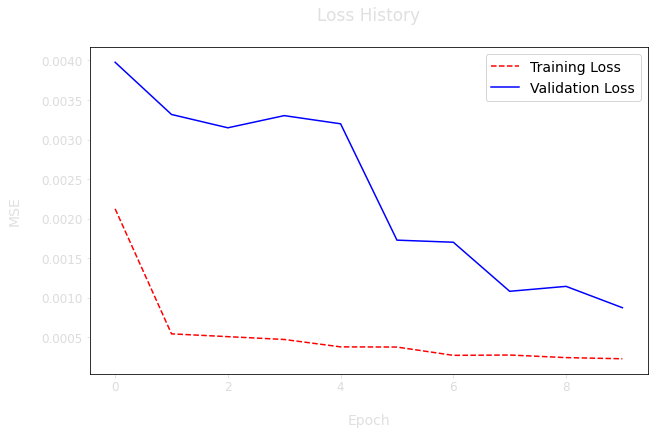

In [14]:
#@title  { form-width: "250px" }
epochs =    200  #@param {type:"integer"}
learning_rate = 5e-4  #@param {type:"number"}

save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"
tf.keras.backend.clear_session()

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
history = model.fit(
    multi_data.tf_datasets["train"].shuffle(buffer_size=multi_data.size["train"]), 
    epochs=epochs,
    validation_data=(val_inputs, val_outputs),
    callbacks=[ClearCallback(),
               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                                     monitor='val_loss', 
                                                     verbose=1, save_best_only=True)],
)

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving the model
model.save(os.path.join(save_path, "full_save"))
model.custom_save(save_path)
shutil.make_archive(save_path, "zip", save_path)

# downloading the model (Colab only)
if COLAB: 
  files.download(f"{save_path}.zip")

# visualizing loss history
clear_output(wait=True)
print(history.history)

plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

if COLAB: Javascript("google.colab.output.setIframeHeight('200px');")

## **4) Evaluating on all the stocks**

In [15]:
loss = {}
for mode in ["train", "val", "test"]:
    loss[mode] = model.evaluate(multi_data.tf_datasets[mode])

loss = pd.Series(loss.values(), index=loss.keys())
print("\n\n>>> Loss value (on the normalized data):")
loss

59/59 [==============================] - 6s 105ms/step - loss: 0.0110


>>> Loss value (on the normalized data):


train    0.000178
val      0.000875
test     0.010980
dtype: float64

In [16]:
results, predictions = {}, {}
i = 0
for stk, sdata in multi_data.stocks:
    clear_output(wait=True)
    print(f"[{100*(i+1) / len(multi_data.stocks) : .0f}%] Evaluating stock {i+1} of {len(multi_data.stocks)}... ", end="")
    i += 1

    results[stk], predictions[stk] = {}, {}
    for mode in ["train", "val", "test"]:
        predictions[stk][mode], results[stk][mode] = eval(model, 
                                                          sdata, mode)
    print("done!")

print("\nResults: ")
results

[ 100%] Evaluating stock 23 of 23... done!

Results: 


{'000001.SS': {'test': {'general': {'mae': 44.161064559731166,
    'mape': 0.014174105386530625,
    'mse': 2730.6702962010677},
   'high': {'mae': 61.82520166483008,
    'mape': 0.019778827597620462,
    'mse': 4587.707081335238,
    'tend_acc': 0.6046511627906976},
   'low': {'mae': 27.087230308353856,
    'mape': 0.008749665745002274,
    'mse': 1306.7769085056373,
    'tend_acc': 0.6046511627906976},
   'open': {'mae': 43.57076170600955,
    'mape': 0.013993822816969124,
    'mse': 2297.5268987623285,
    'tend_acc': 0.6046511627906976}},
  'train': {'general': {'mae': 51.64028018472353,
    'mape': 0.019494040933662662,
    'mse': 4331.941678710363},
   'high': {'mae': 62.70157275970748,
    'mape': 0.023724993693131347,
    'mse': 5177.054563238487,
    'tend_acc': 0.565742251223491},
   'low': {'mae': 40.852145609054496,
    'mape': 0.015081566311860077,
    'mse': 4134.872632796861,
    'tend_acc': 0.6104404567699837},
   'open': {'mae': 51.367122185408746,
    'mape': 0.019675

## **5) Visualizing results for individual stocks**

#### **5.1) Training data**

In [17]:
symbols = ["^BVSP", "^DJI", "^HSI", "^IXIC", "^FTSE"]

[^BVSP] Training Data

#########################

[> GENERAL <]
   . MAE:   560
   . MAPE:  1.0490%
   . MSE:   539879

#########################

[> OPEN <]
   . MAE:   454
   . MAPE:  0.8724%
   . MSE:   323711
   . Tendency Accuracy:  77.4390%

#########################

[> LOW <]
   . MAE:   662
   . MAPE:  1.2680%
   . MSE:   750587
   . Tendency Accuracy:  57.5417%

#########################

[> HIGH <]
   . MAE:   564
   . MAPE:  1.0067%
   . MSE:   545338
   . Tendency Accuracy:  63.0937%

#########################





[^DJI] Training Data

#########################

[> GENERAL <]
   . MAE:   118
   . MAPE:  1.0347%
   . MSE:   19965

#########################

[> OPEN <]
   . MAE:   160
   . MAPE:  1.4076%
   . MSE:   29511
   . Tendency Accuracy:  64.1317%

#########################

[> LOW <]
   . MAE:   86
   . MAPE:  0.7600%
   . MSE:   13810
   . Tendency Accuracy:  62.3677%

#########################

[> HIGH <]
   . MAE:   108
   . MAPE:  0.9365%
   . MSE:   16575
   .

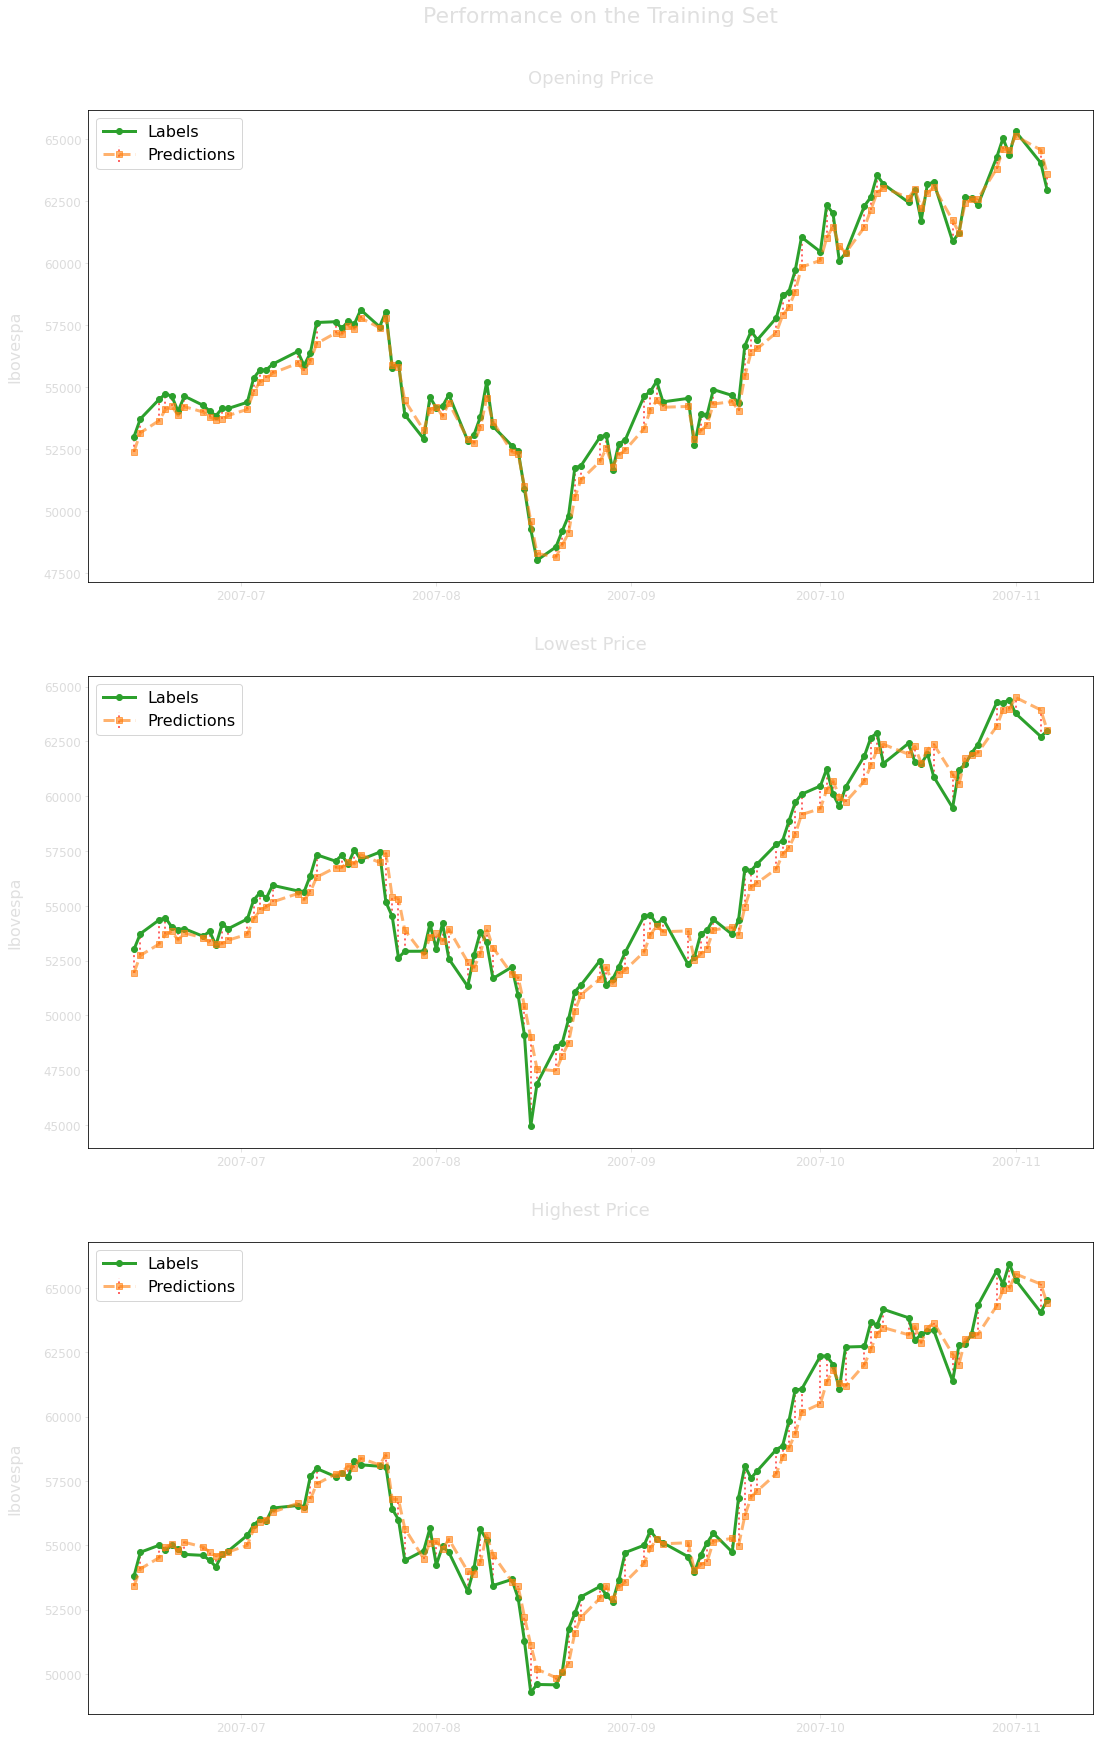

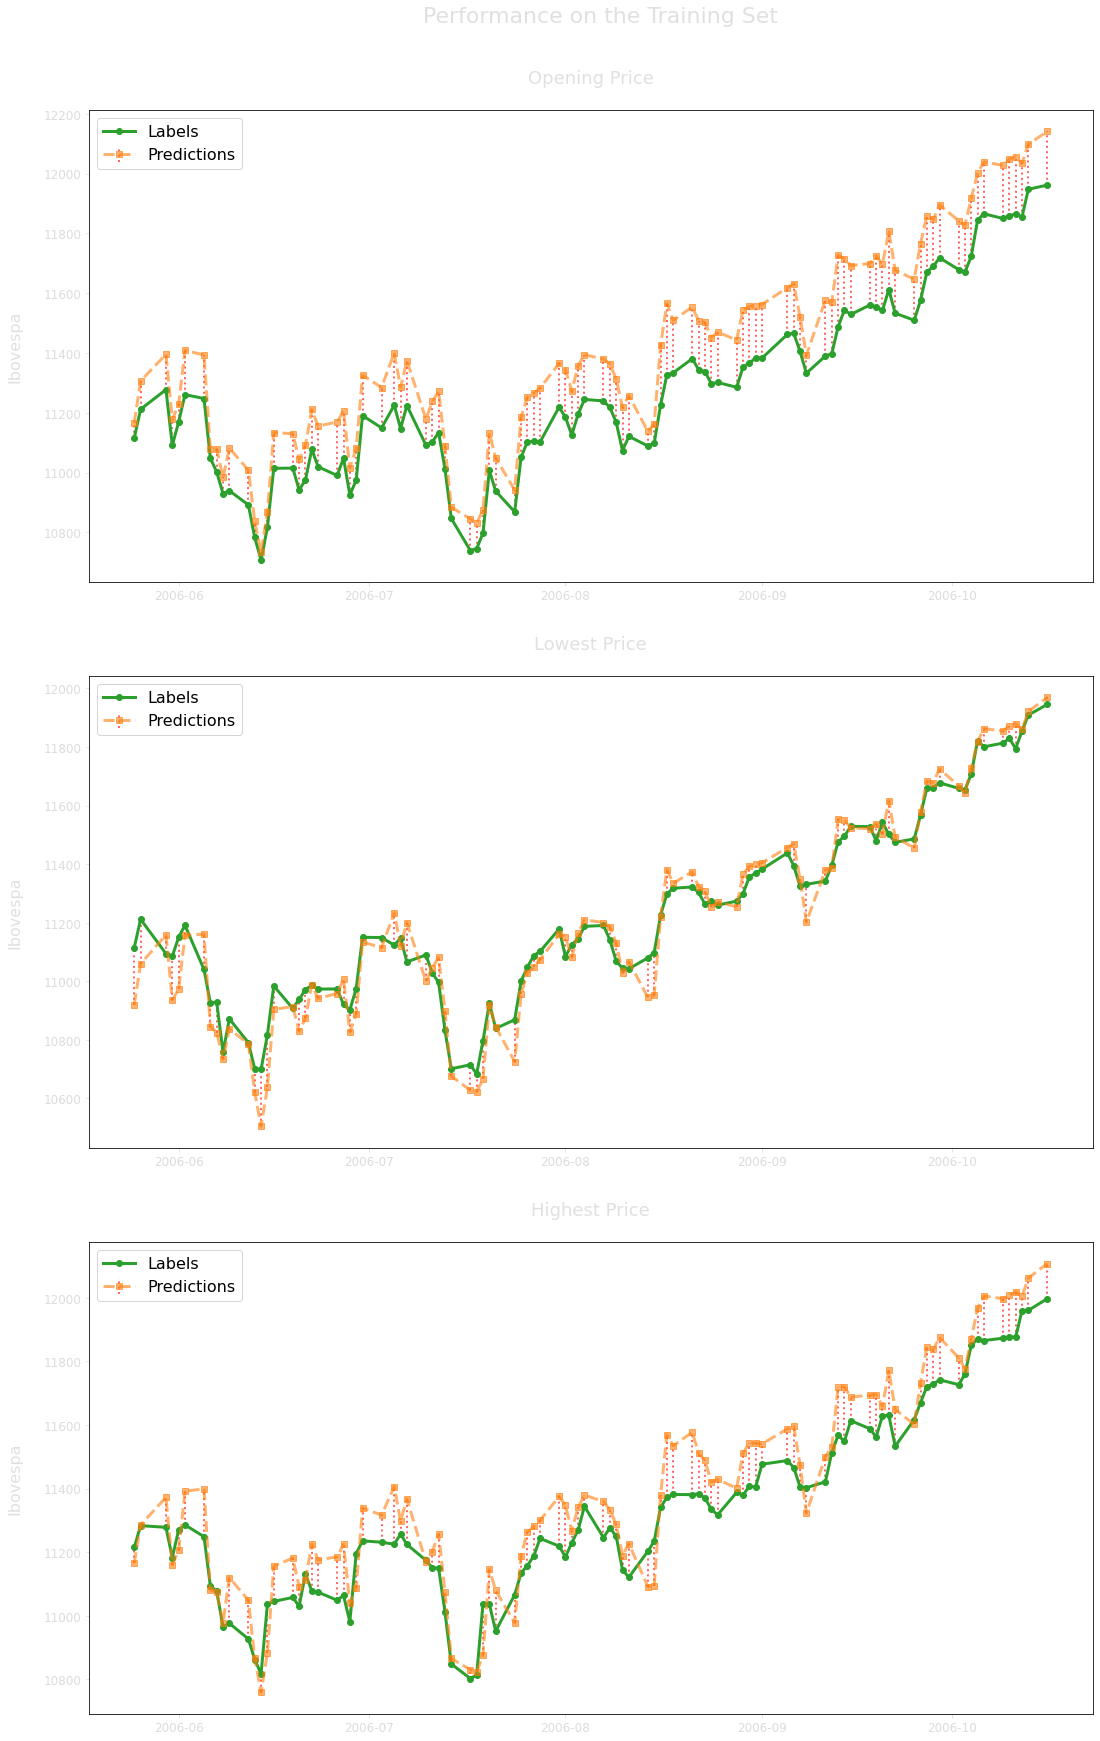

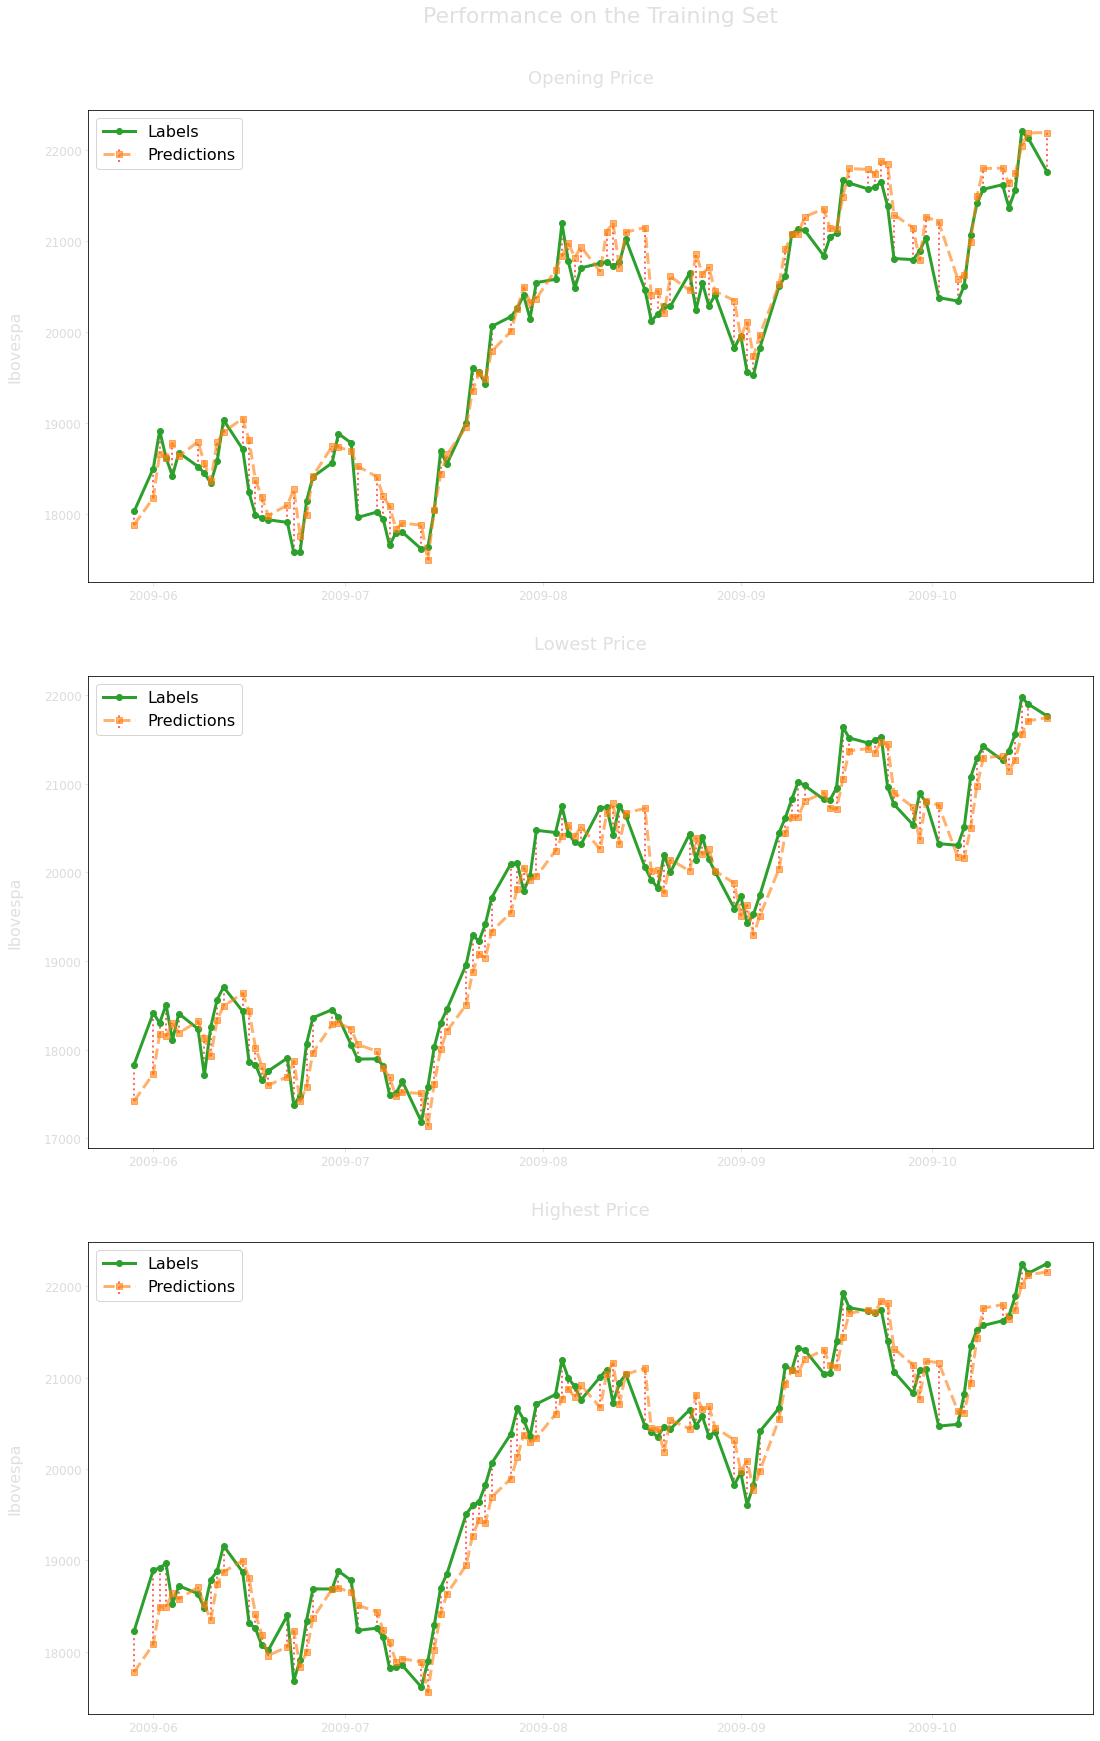

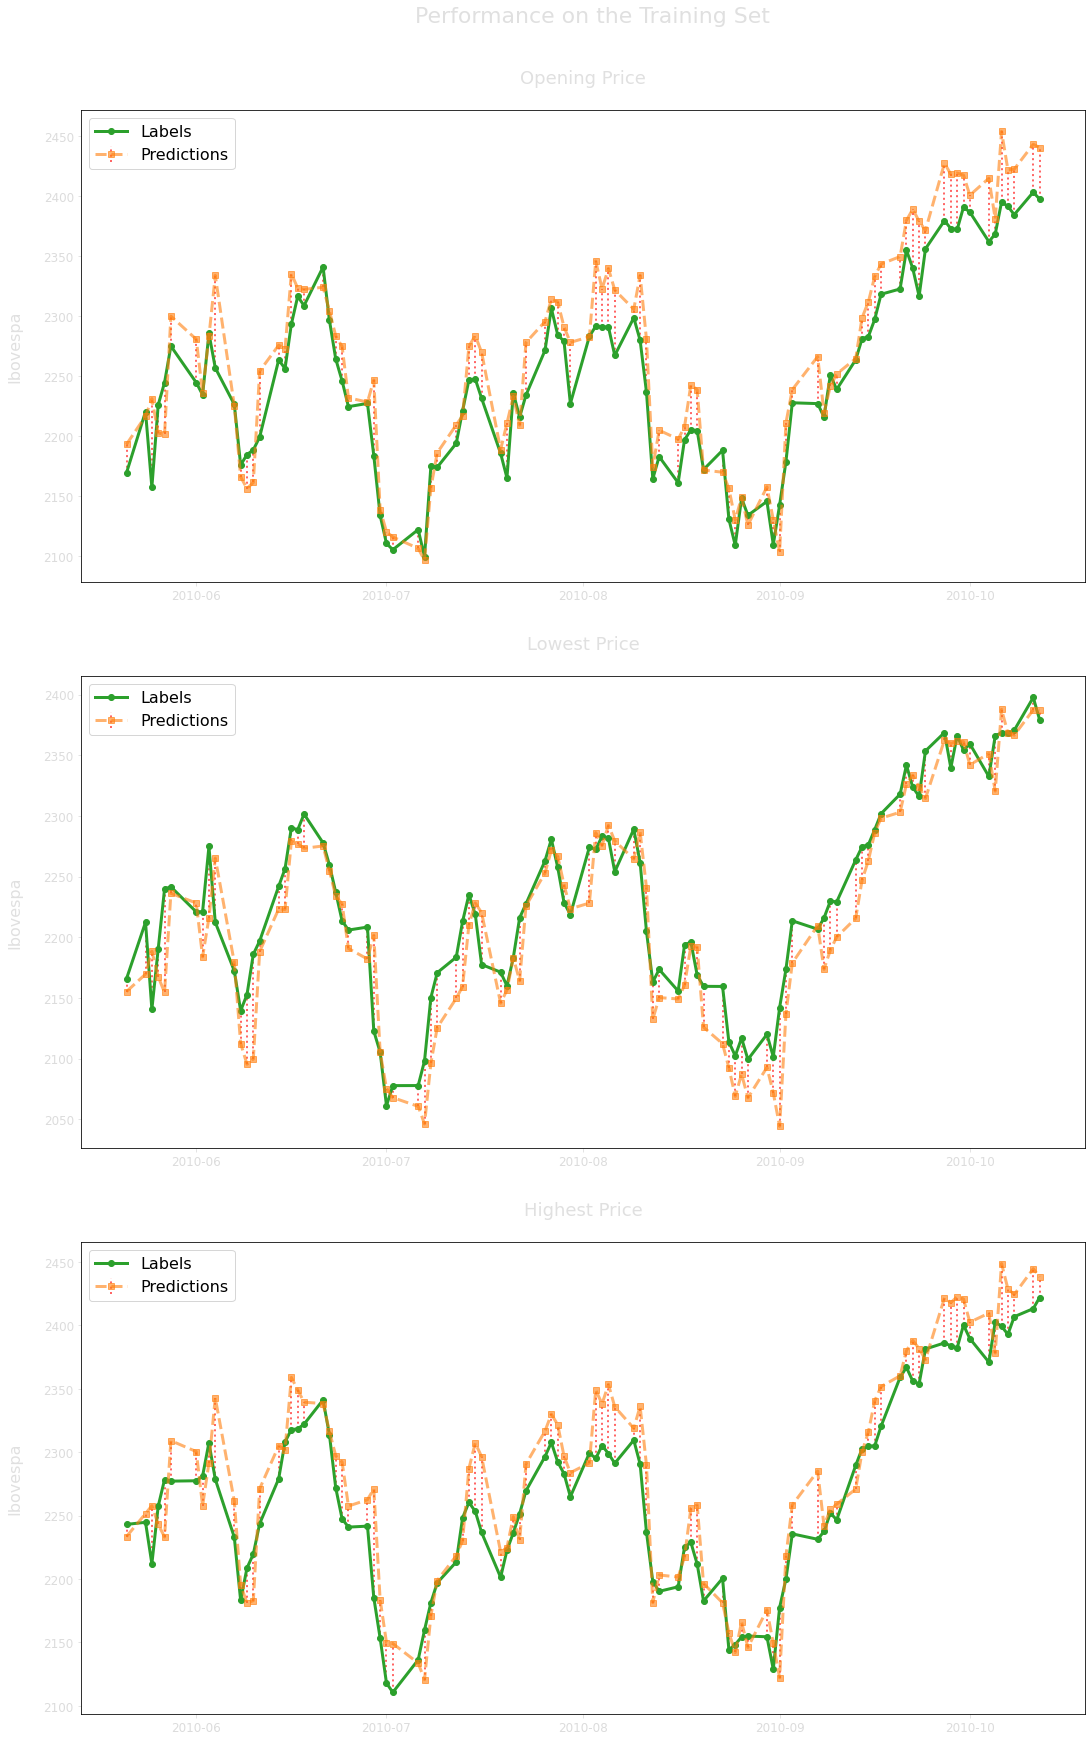

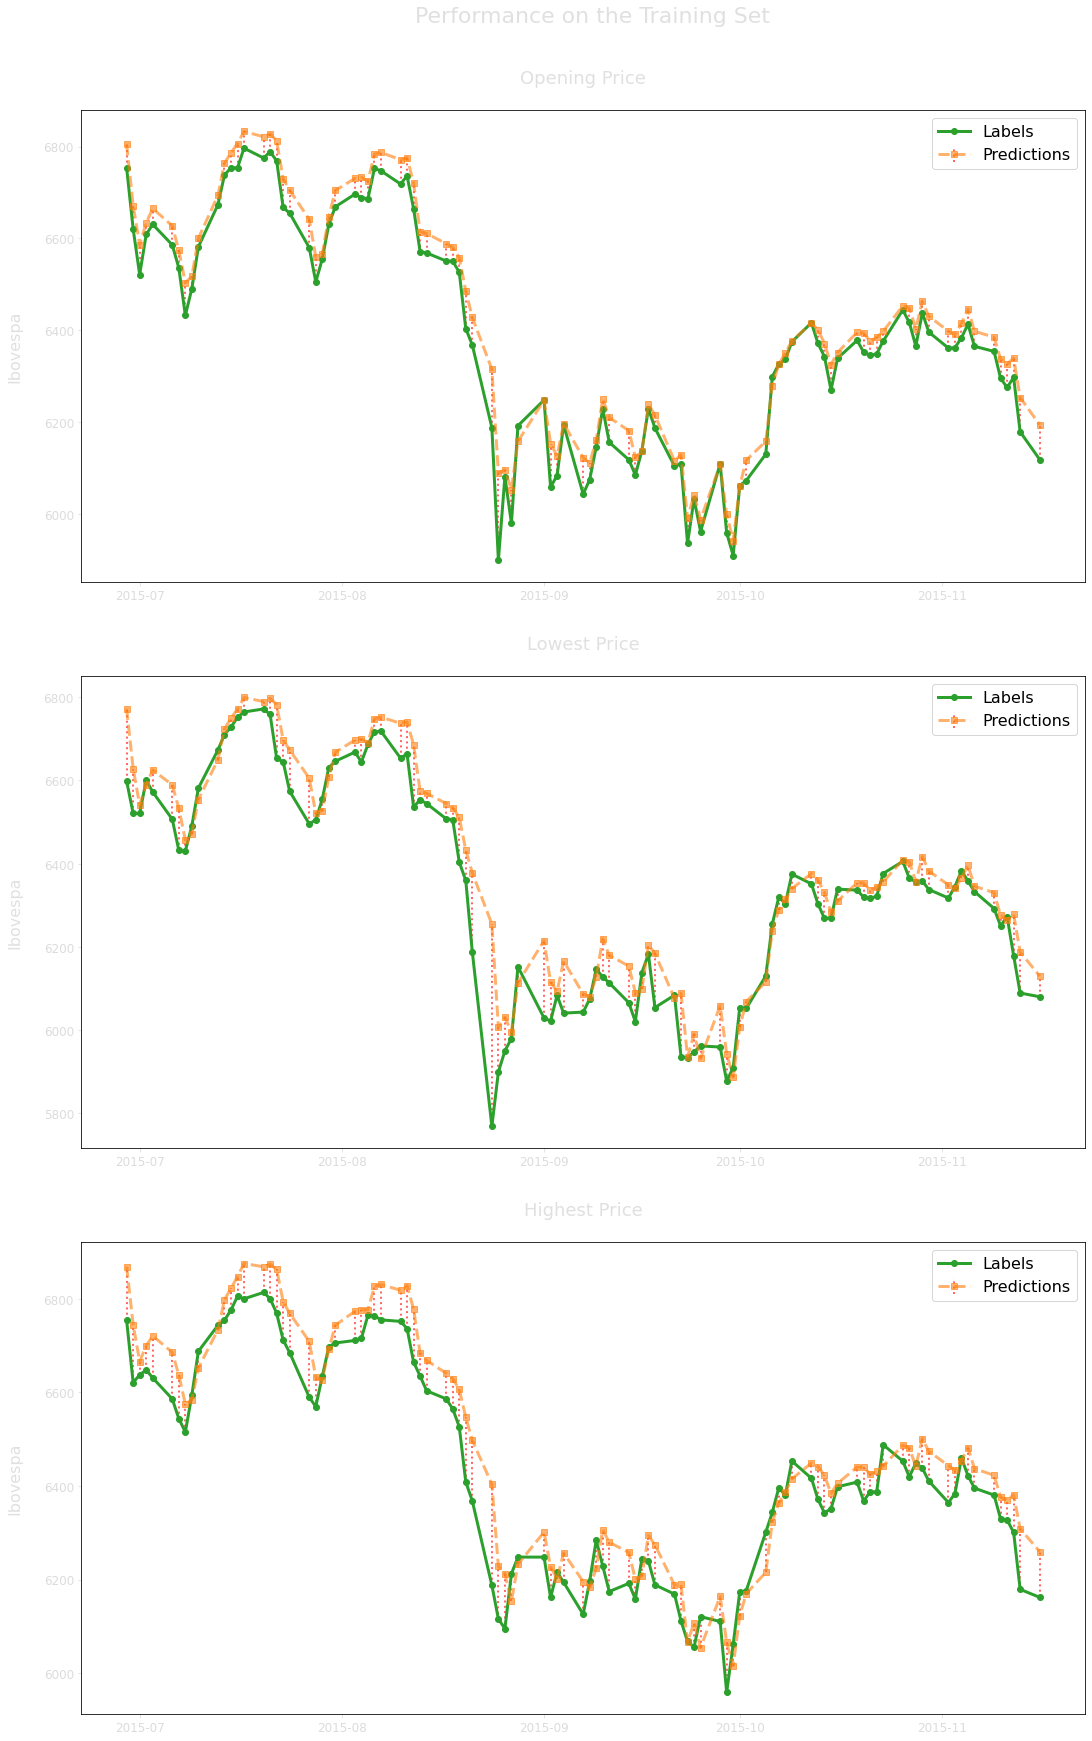

In [18]:
for symb in symbols:
  print(f"[{symb}] Training Data\n")
  eval_print(results[symb]["train"])
  eval_plot(predictions[symb]["train"], 
            multi_data[symb].raw_train["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Training Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.2) Validation data**

[^BVSP] Validation Data

#########################

[> GENERAL <]
   . MAE:   1667
   . MAPE:  1.5833%
   . MSE:   5507941

#########################

[> OPEN <]
   . MAE:   1000
   . MAPE:  0.9571%
   . MSE:   1940520
   . Tendency Accuracy:  70.1950%

#########################

[> LOW <]
   . MAE:   1808
   . MAPE:  1.7299%
   . MSE:   5863530
   . Tendency Accuracy:  49.8607%

#########################

[> HIGH <]
   . MAE:   2194
   . MAPE:  2.0630%
   . MSE:   8719771
   . Tendency Accuracy:  50.1393%

#########################





[^DJI] Validation Data

#########################

[> GENERAL <]
   . MAE:   538
   . MAPE:  2.1175%
   . MSE:   406107

#########################

[> OPEN <]
   . MAE:   408
   . MAPE:  1.6120%
   . MSE:   225126
   . Tendency Accuracy:  48.1419%

#########################

[> LOW <]
   . MAE:   573
   . MAPE:  2.2623%
   . MSE:   451224
   . Tendency Accuracy:  44.9324%

#########################

[> HIGH <]
   . MAE:   633
   . MAPE:  2.4780%
   . M

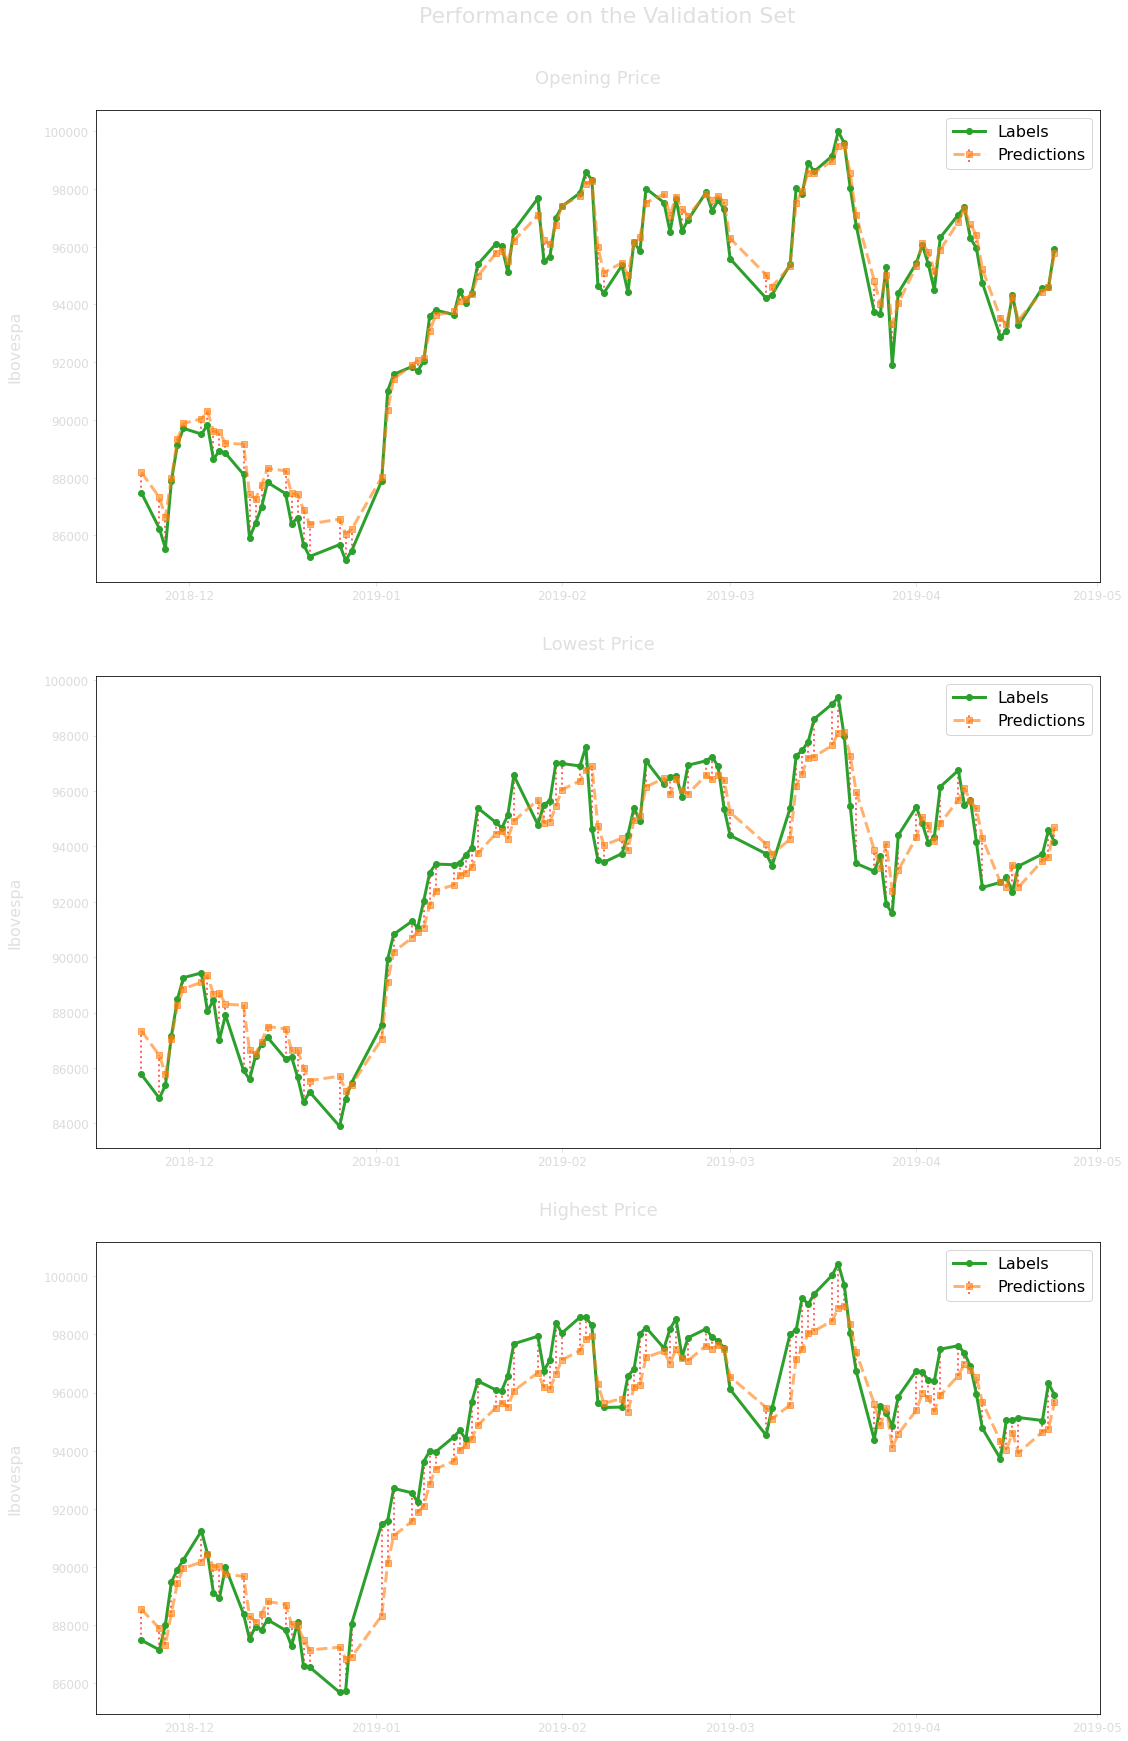

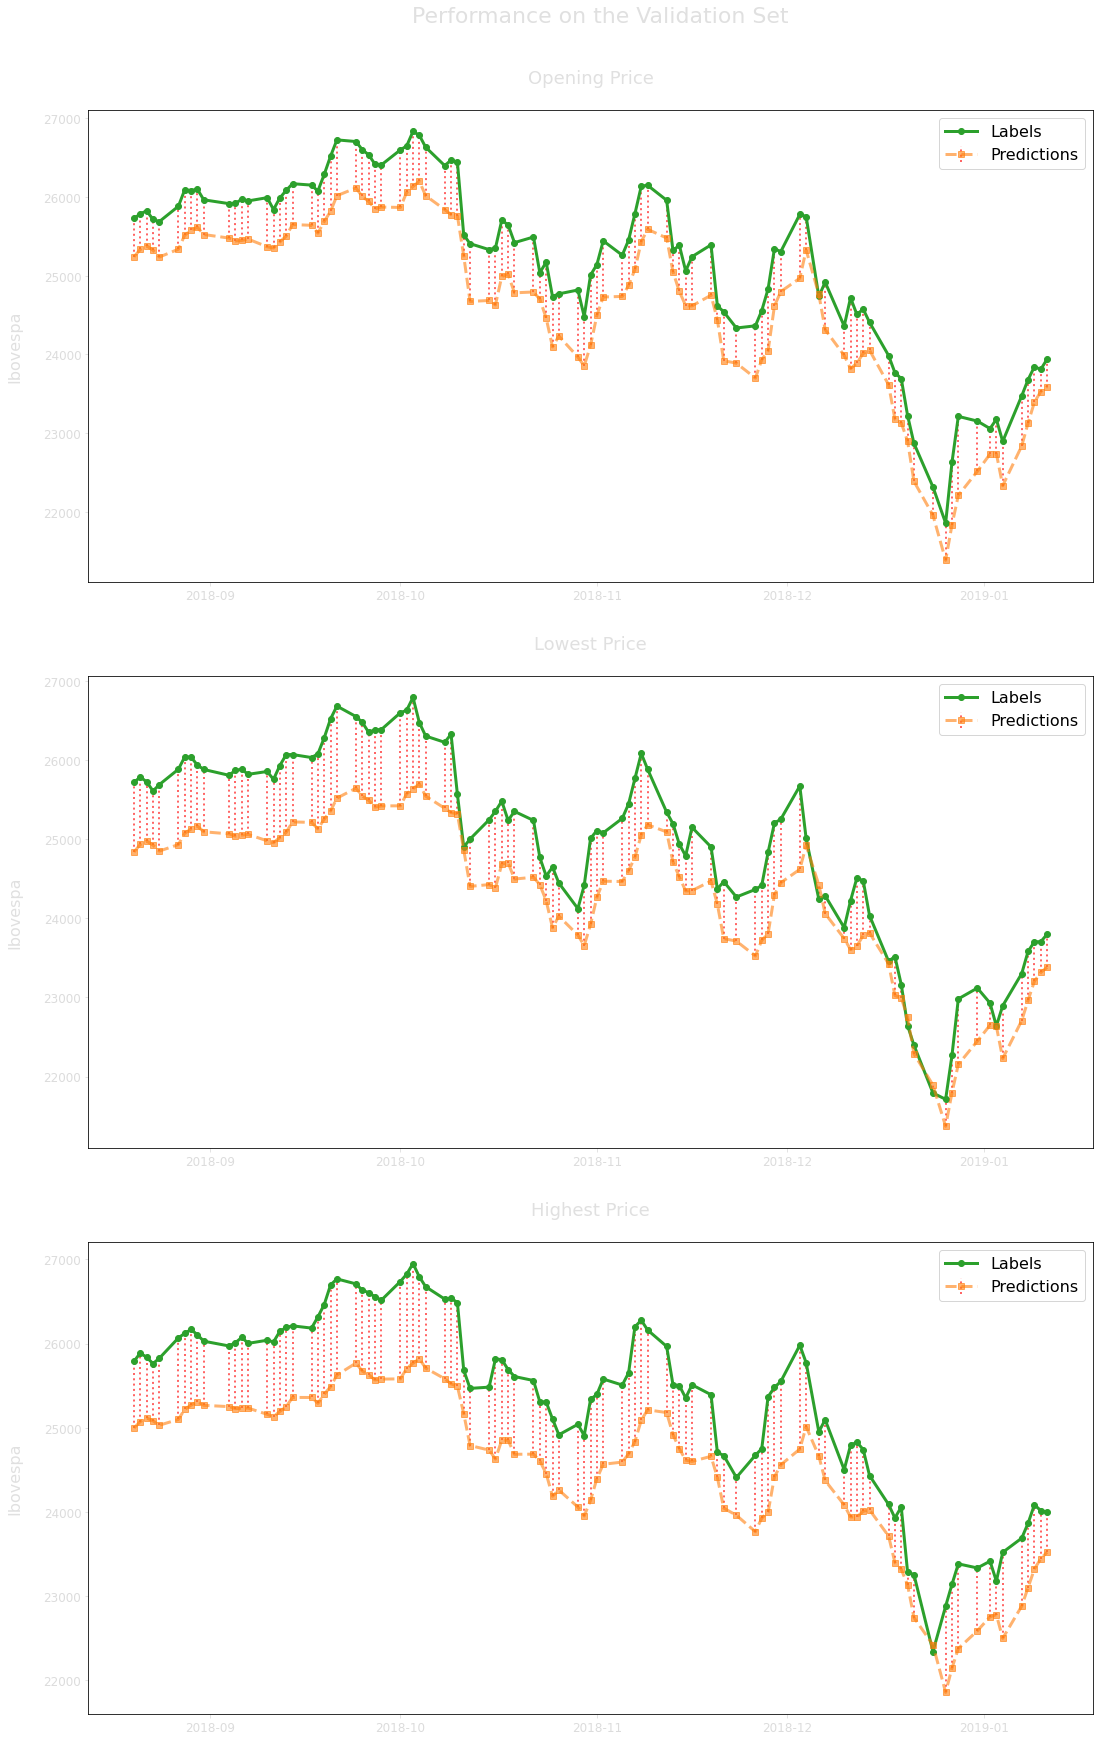

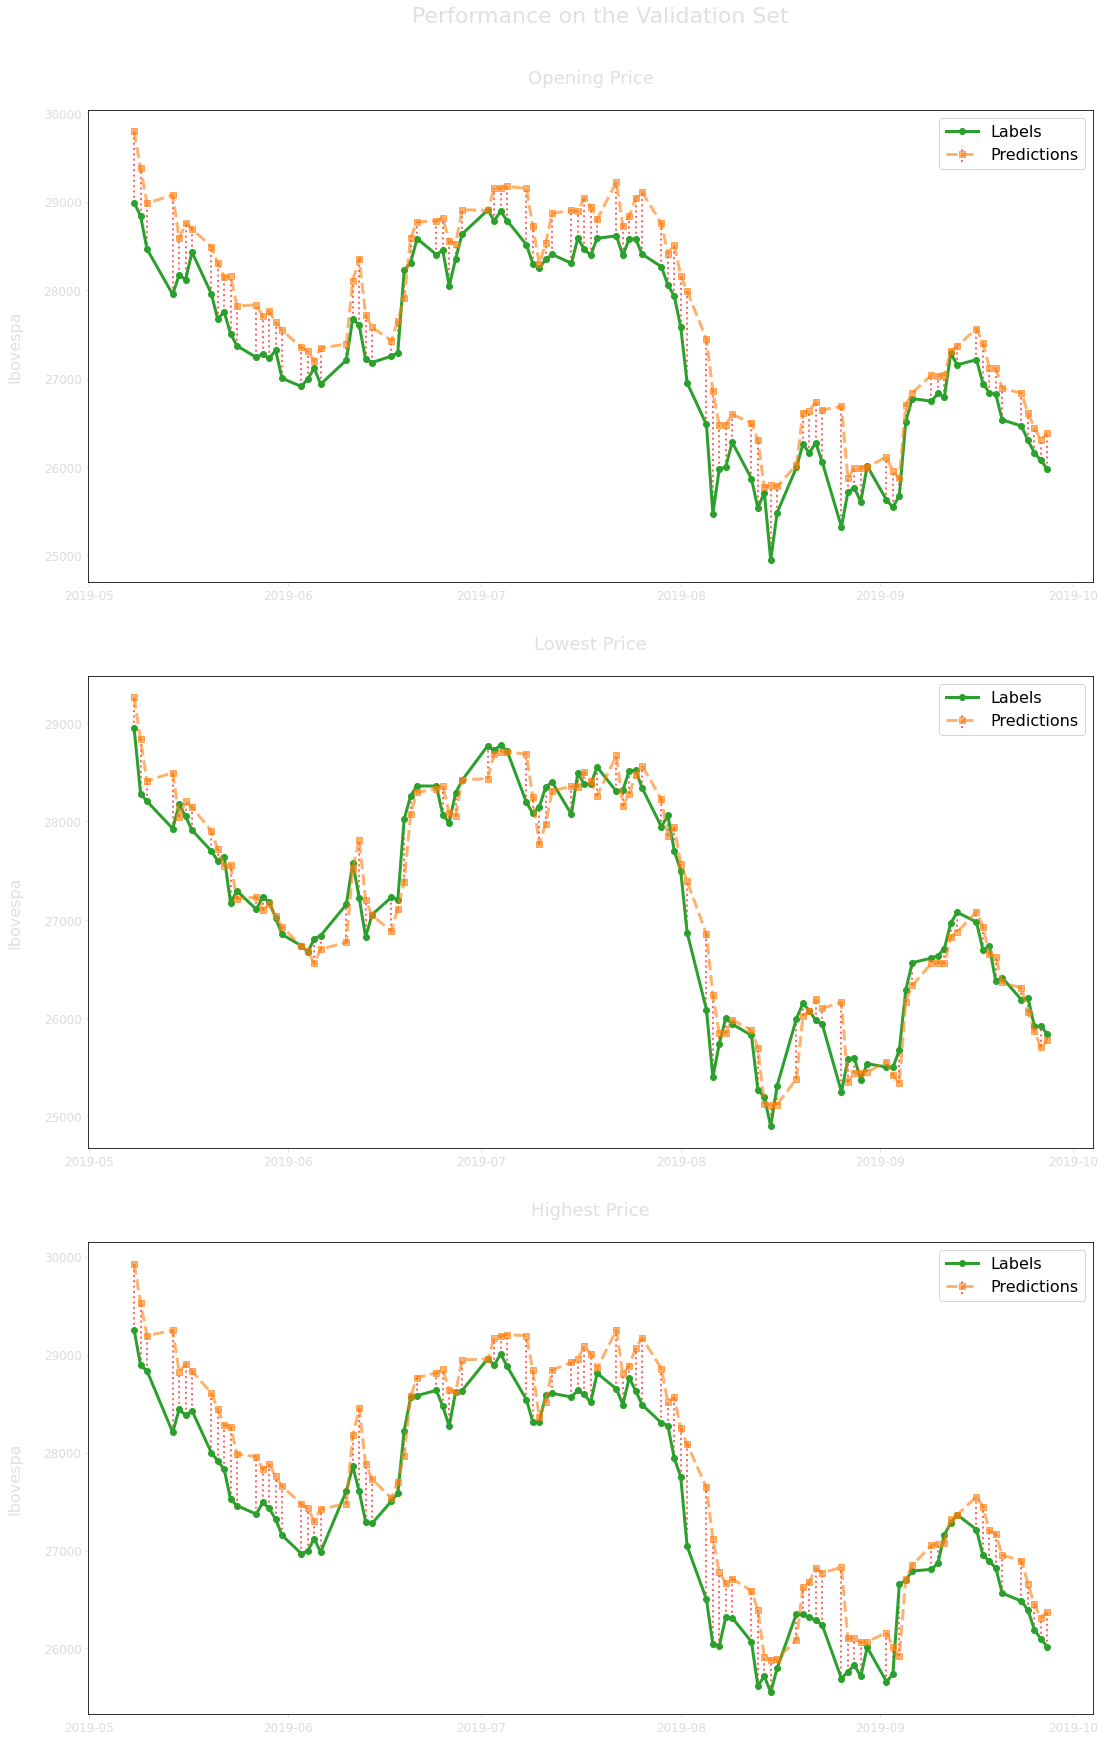

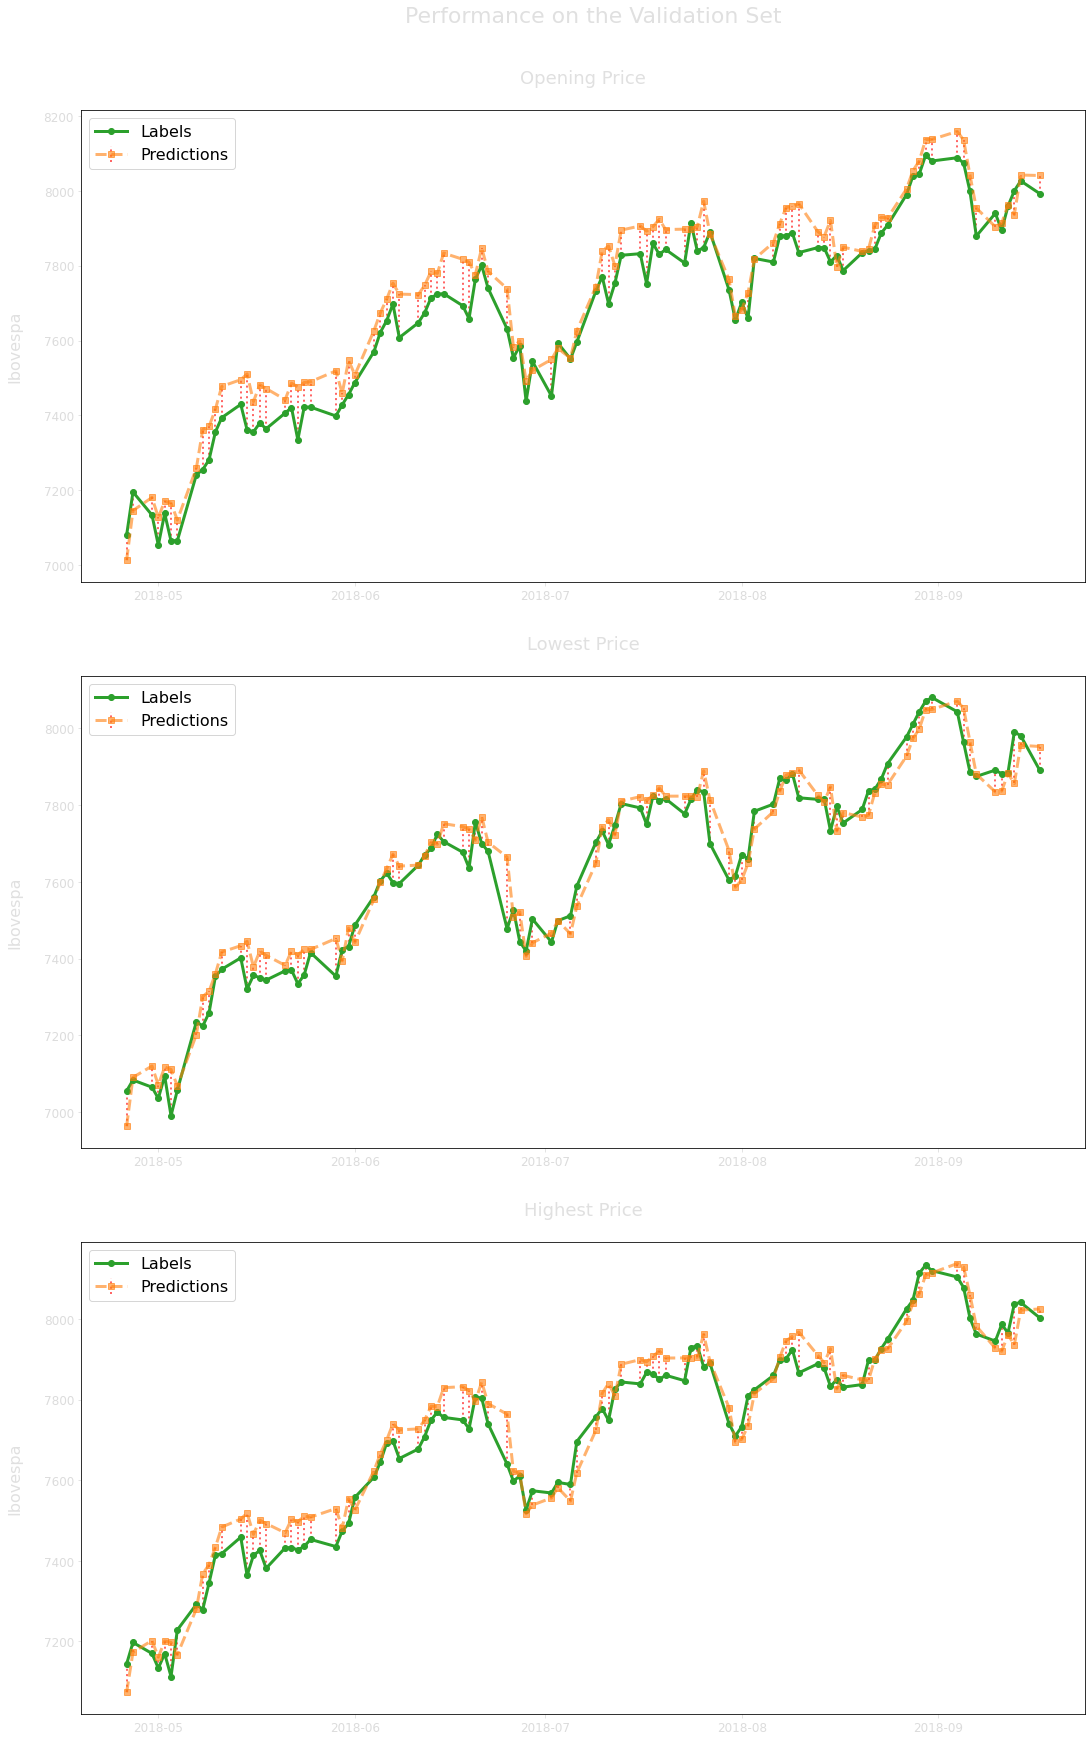

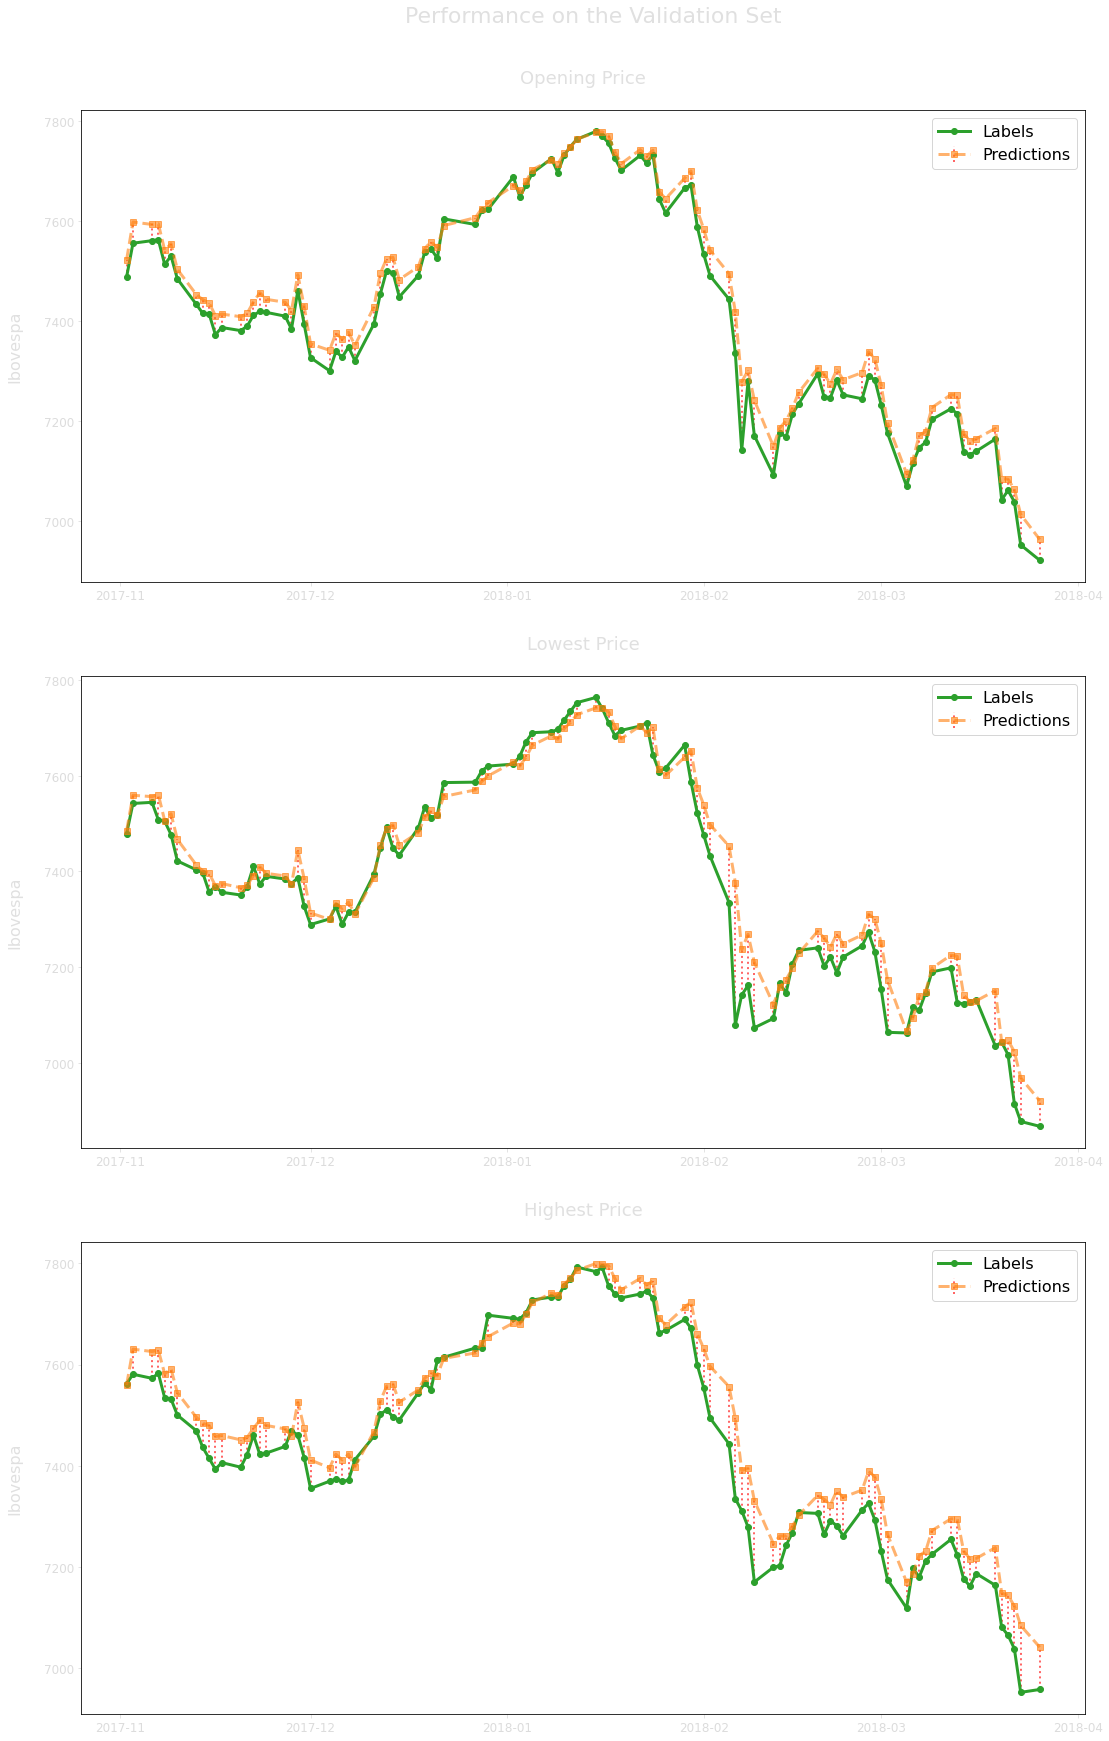

In [19]:
for symb in symbols:
  print(f"[{symb}] Validation Data\n")
  eval_print(results[symb]["val"])
  eval_plot(predictions[symb]["val"], 
            multi_data[symb].raw_val["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Validation Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.3) Test data**

[^BVSP] Test Data

#########################

[> GENERAL <]
   . MAE:   1491
   . MAPE:  1.6489%
   . MSE:   4150352

#########################

[> OPEN <]
   . MAE:   949
   . MAPE:  1.1023%
   . MSE:   2025894
   . Tendency Accuracy:  80.0000%

#########################

[> LOW <]
   . MAE:   1514
   . MAPE:  1.7074%
   . MSE:   3910190
   . Tendency Accuracy:  52.5714%

#########################

[> HIGH <]
   . MAE:   2010
   . MAPE:  2.1369%
   . MSE:   6514971
   . Tendency Accuracy:  46.2857%

#########################





[^DJI] Test Data

#########################

[> GENERAL <]
   . MAE:   1205
   . MAPE:  4.4756%
   . MSE:   1776834

#########################

[> OPEN <]
   . MAE:   939
   . MAPE:  3.5460%
   . MSE:   1101238
   . Tendency Accuracy:  42.3208%

#########################

[> LOW <]
   . MAE:   1223
   . MAPE:  4.5365%
   . MSE:   1780835
   . Tendency Accuracy:  44.7099%

#########################

[> HIGH <]
   . MAE:   1454
   . MAPE:  5.3443%
   . MSE:   2

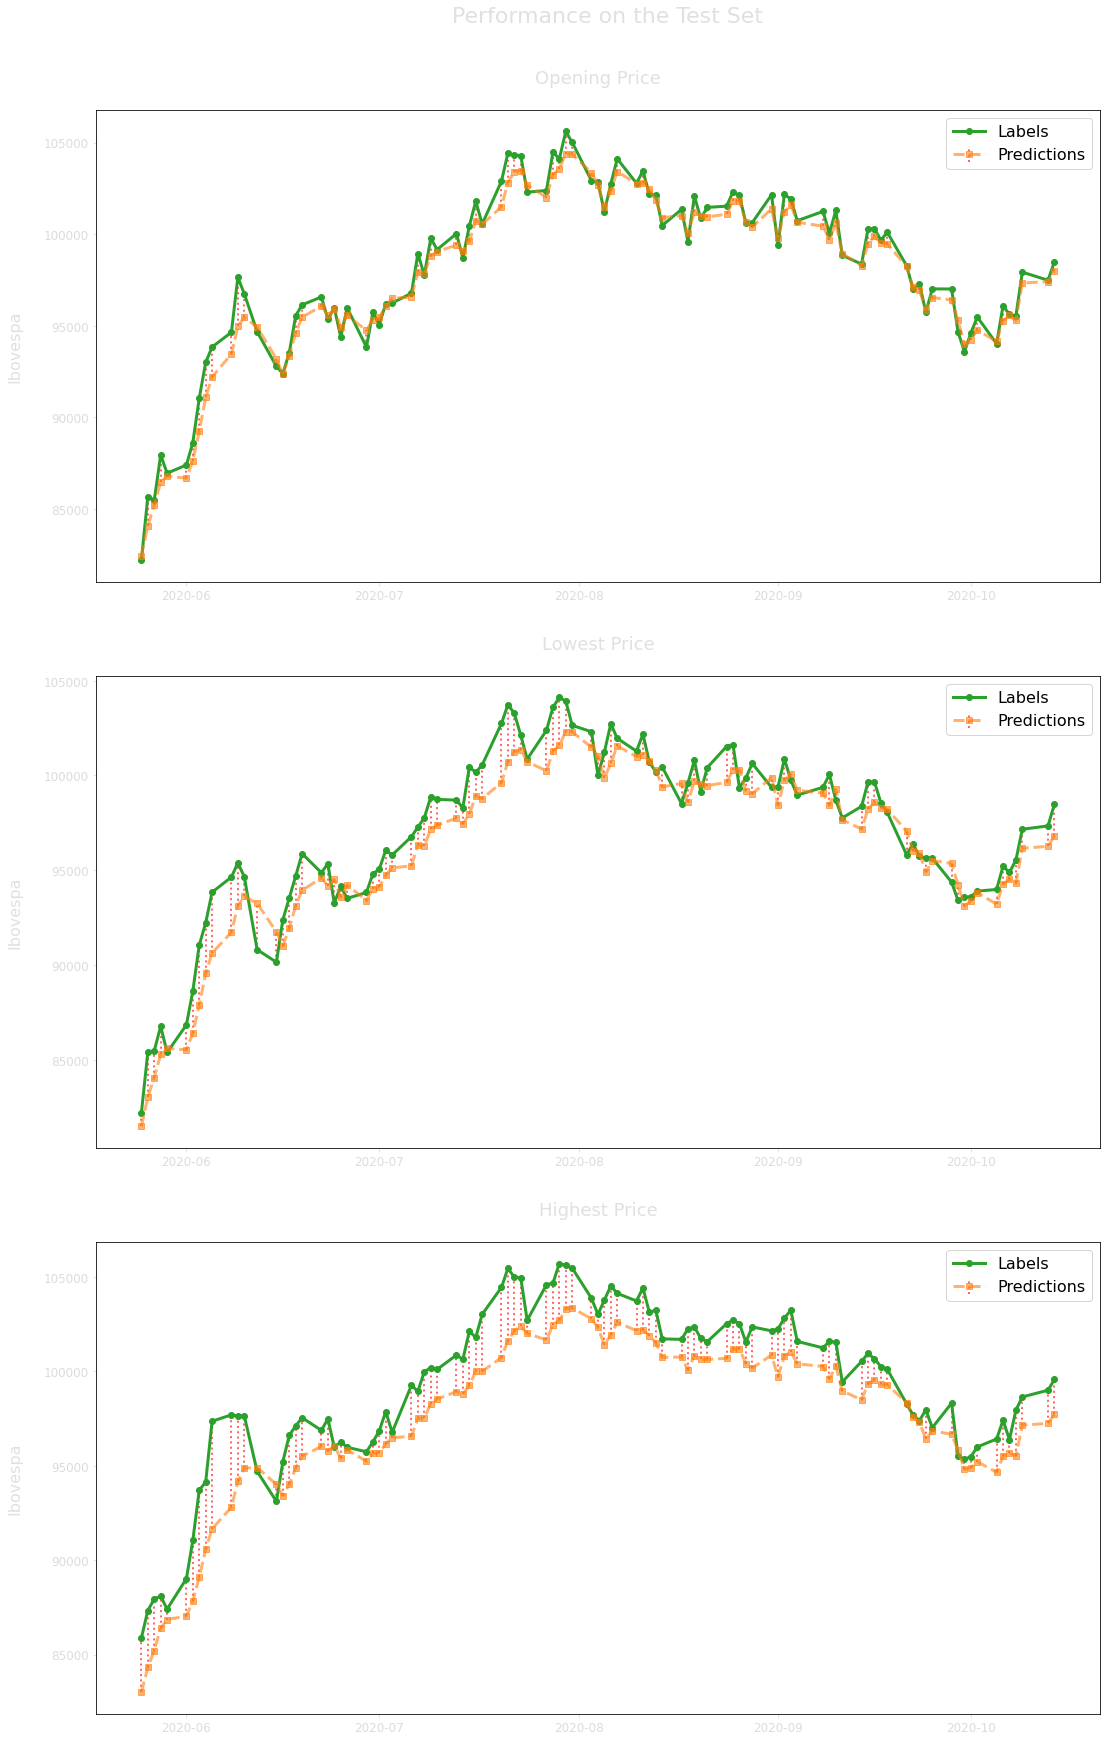

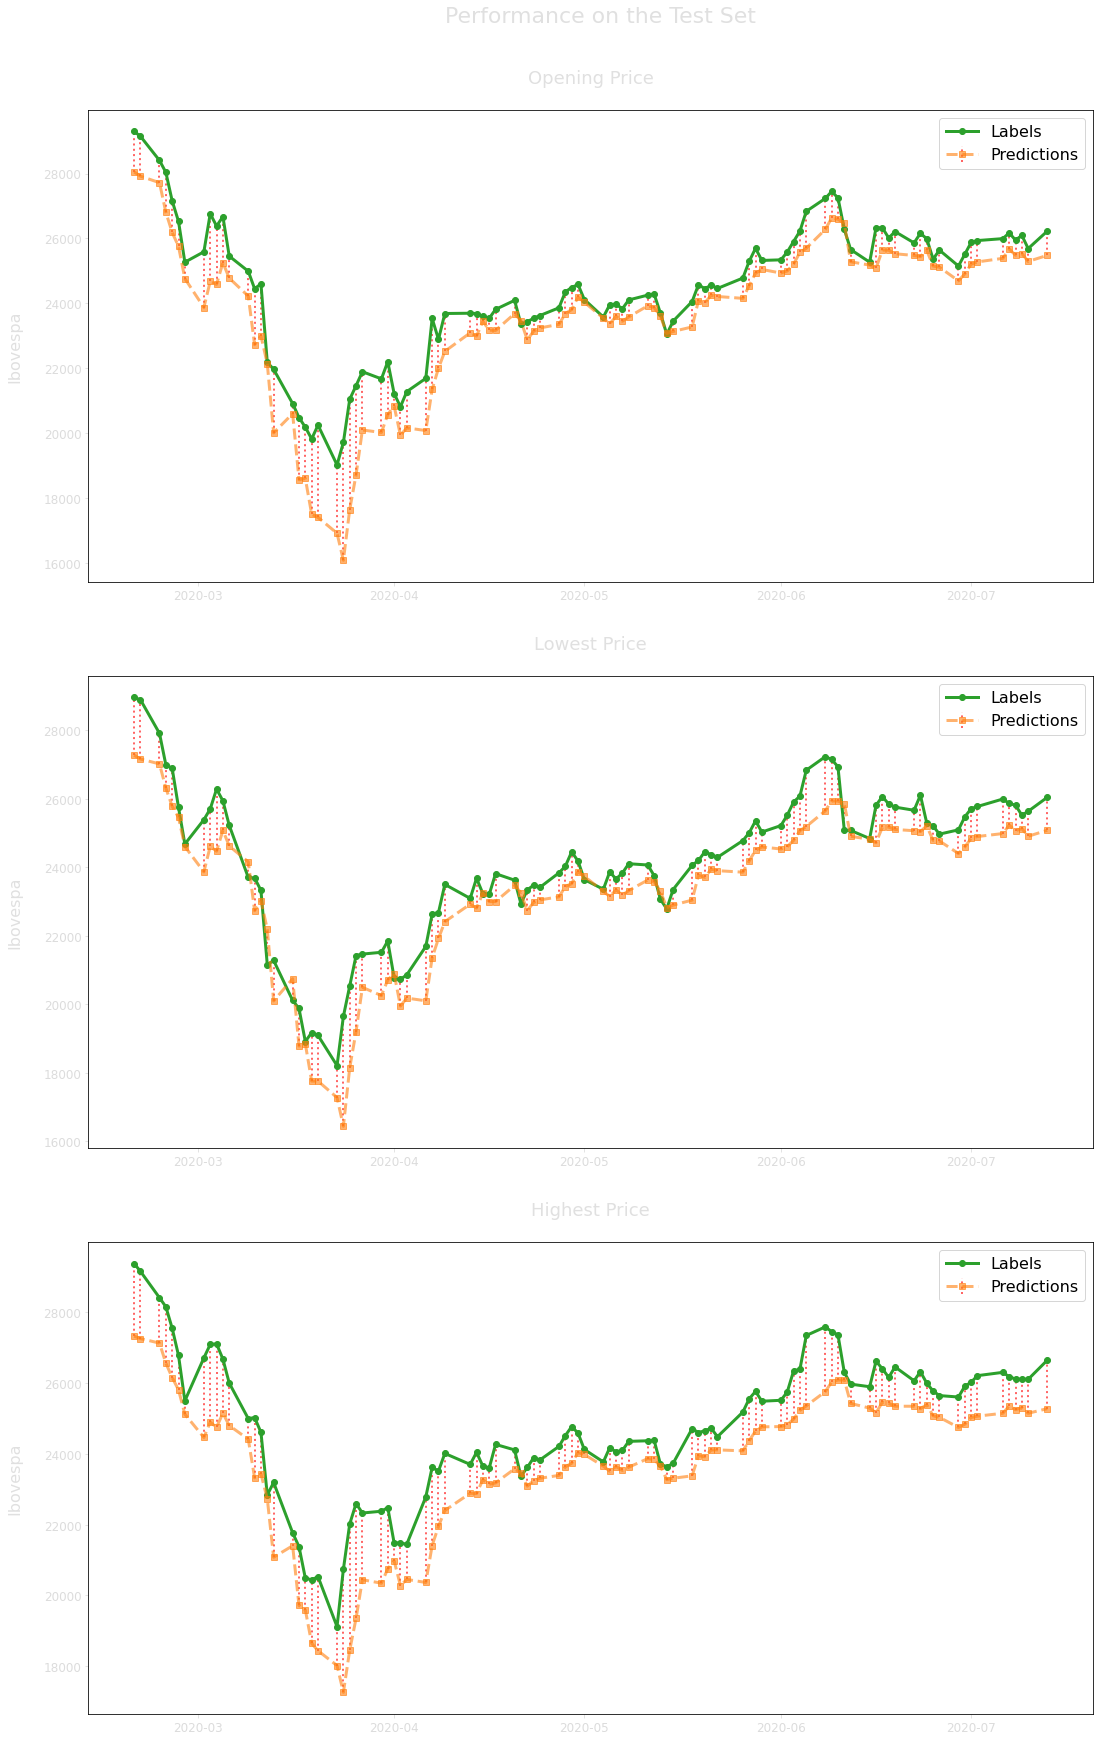

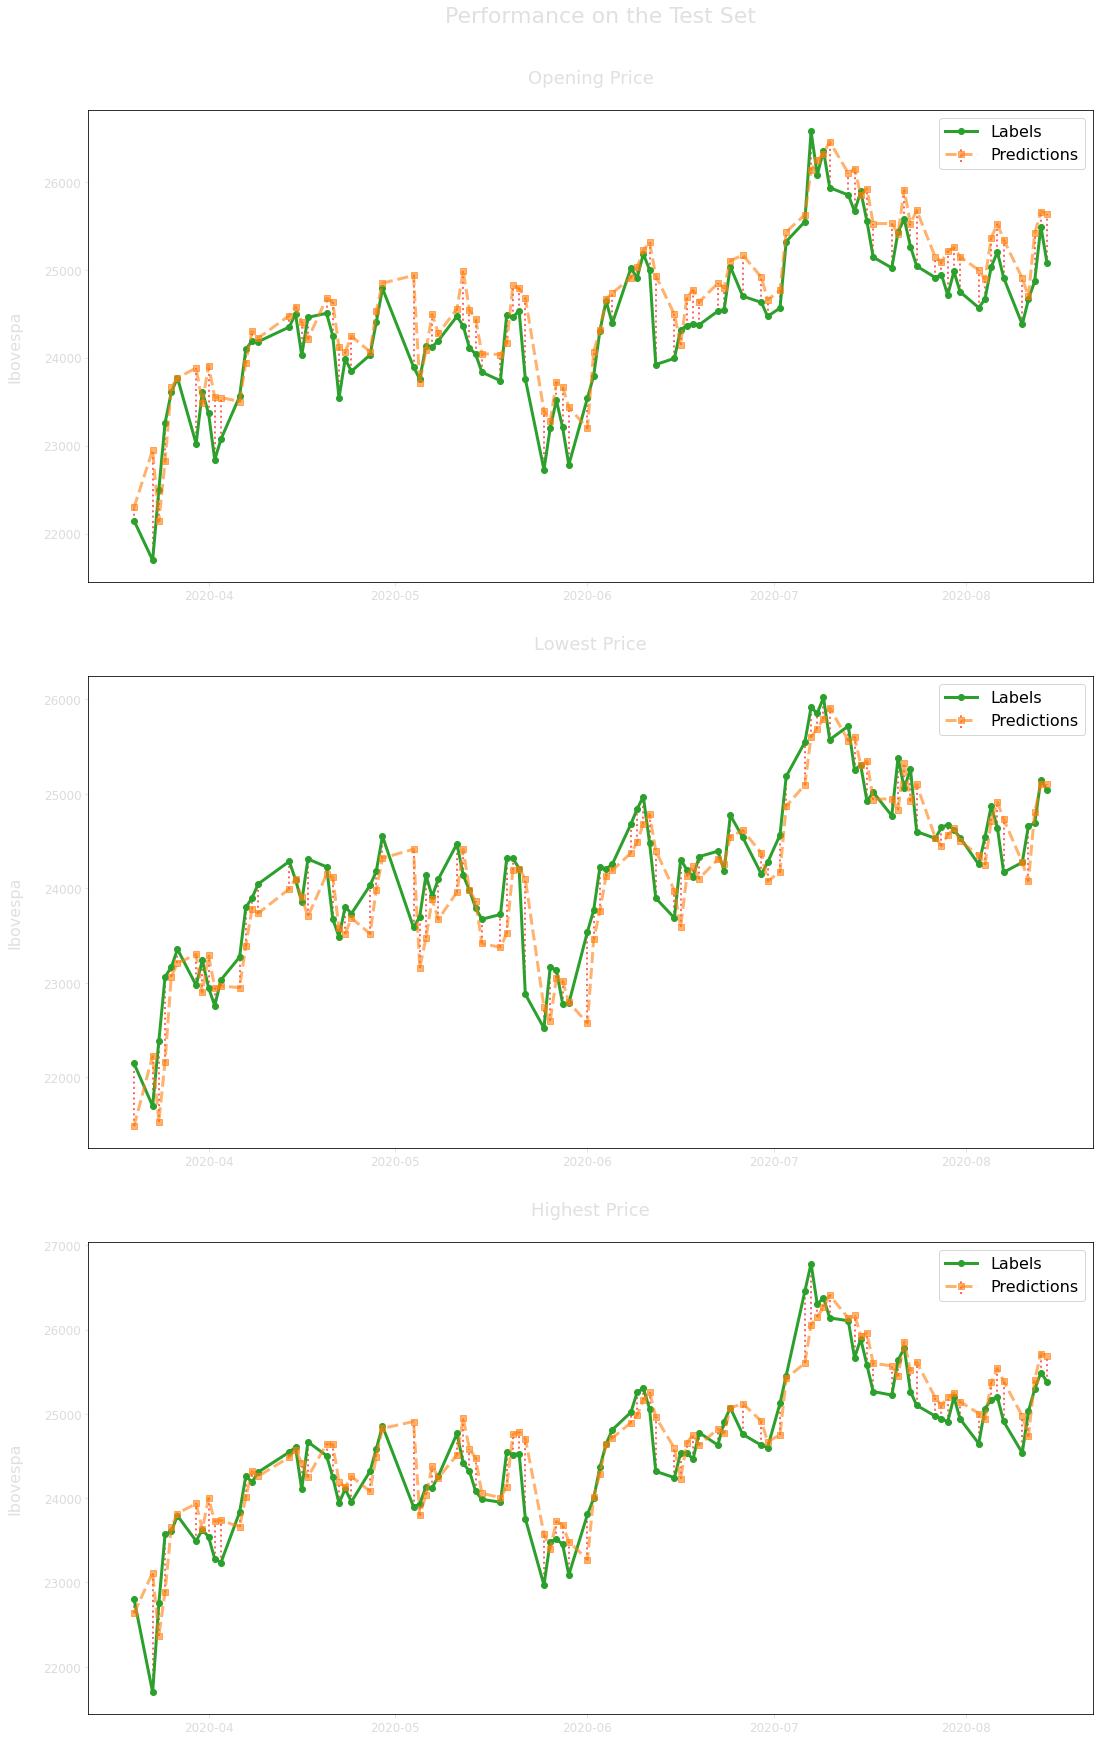

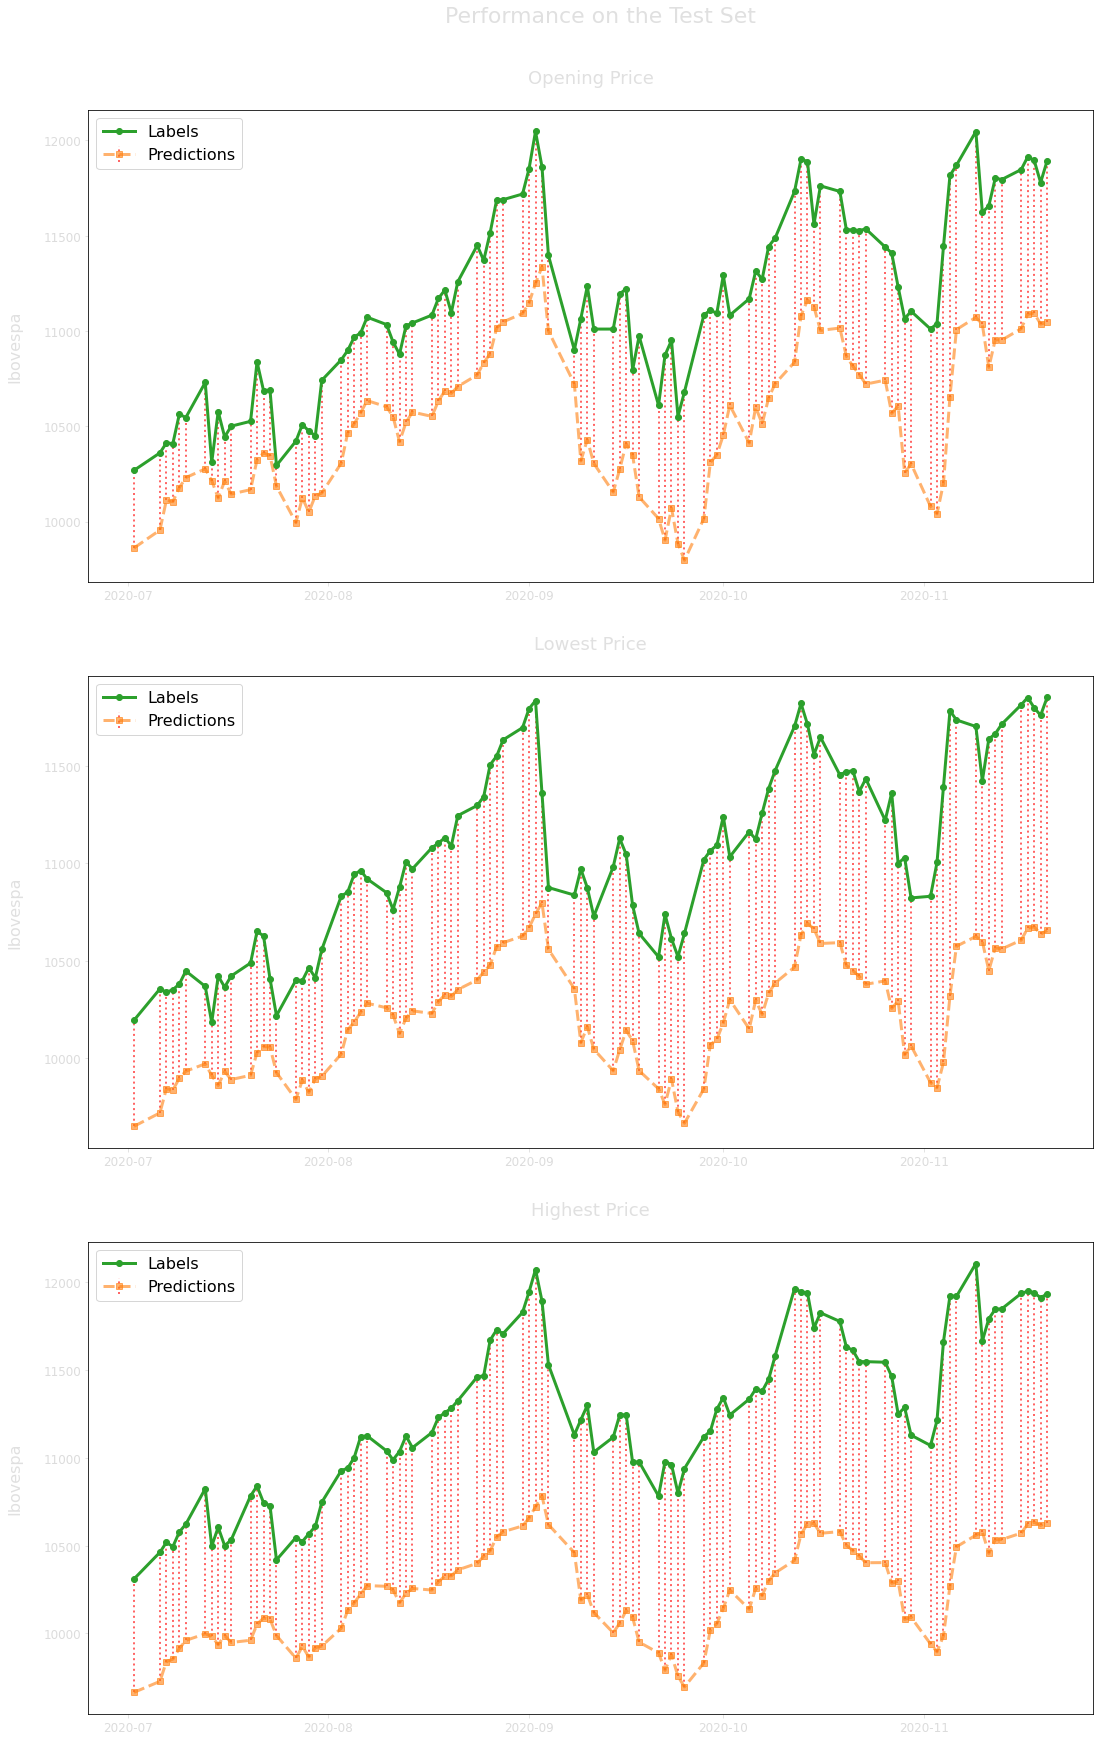

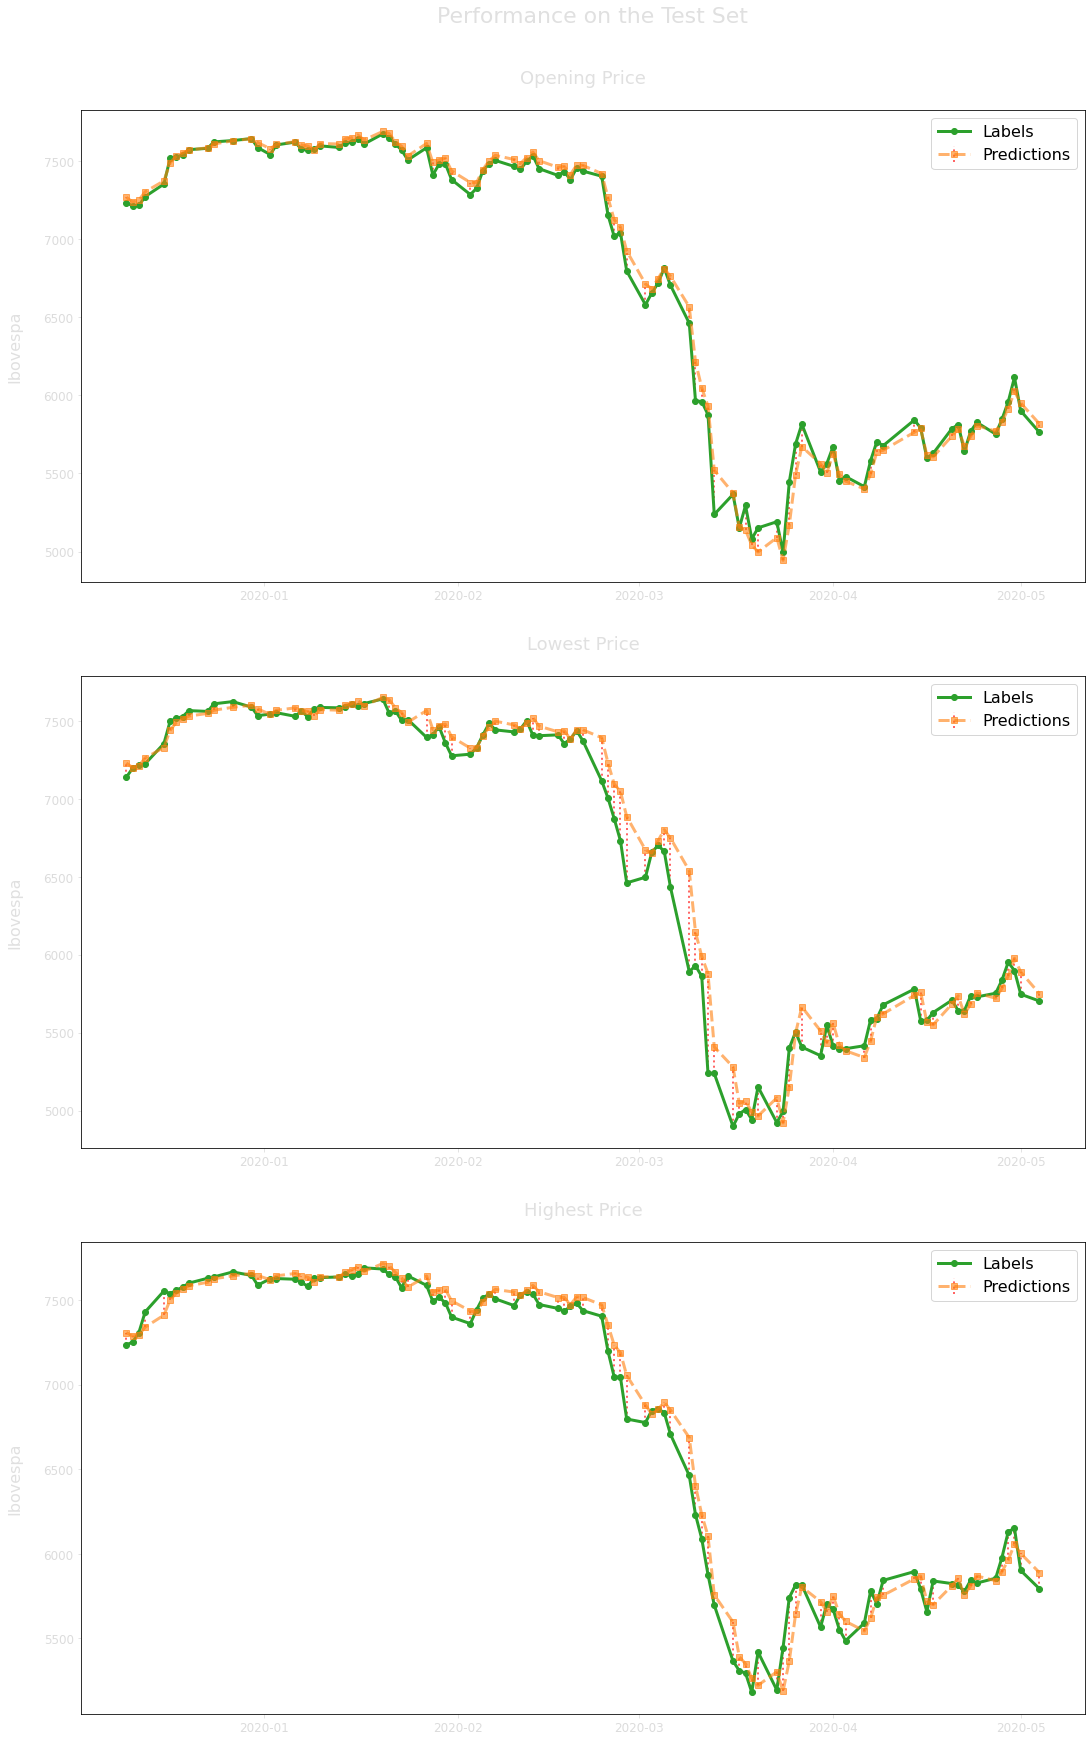

In [20]:
for symb in symbols:
  print(f"[{symb}] Test Data\n")
  eval_print(results[symb]["test"])
  eval_plot(predictions[symb]["test"], 
            multi_data[symb].raw_test["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Test Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")